In [2]:
# -------- #
# PACKAGES #
# -------- #
import time
import pickle
import torch
import torch.nn          as nn
import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt 
import seaborn           as sns

from torch.utils.data import Dataset, DataLoader
from my_utils.preprocessing_helpers import convert_column_types

# ---------------- #
# GENERAL SETTINGS #
# ---------------- #
torch.manual_seed(42)
sns.set_theme(style="white")

# ---------------- #
# GLOBAL VARIABLES #
# ---------------- #
from config import (
    # Drug features.
    PATH_TO_SAVED_DRUG_FEATURES,
    DRUG_FPS_FINAL_FILE_NAME,
    # Cell line features.
    PATH_TO_SAVED_CL_FEATURES,
    GENE_EXPR_FINAL_FILE_NAME,
    CNV_GISTIC_FINAL_FILE_NAME,
    CNV_PICNIC_FINAL_FILE_NAME    
)

---

# Building a Baseline Model

The objective of this notebook is to research on how to build a baseline model to test the future GNN approach against. It should be a Deep Learning model for Drug Response Prediction with the following general structure.

<p align="center">
    <img src="imgs/GeneralDLModelForDRP.png" alt="drawing" width="400"/>
</p>

In [3]:
PATH_TO_SAVE_MODELS_TO = '../../datasets/models/'
PATH_TO_SAVE_DATA_TO = '../../datasets/gdsc/my_datasets/'

---

## Cell Features

In [4]:
# --------------- #
# GENE EXPRESSION #
# --------------- #
start = time.time()
gene_expr = pd.read_pickle(f'{PATH_TO_SAVED_CL_FEATURES}{GENE_EXPR_FINAL_FILE_NAME}')
print(f"Shape: {gene_expr.shape} took {time.time()-start:.5f} seconds.")
print(f"  Number of unique cell-lines : {len(np.unique(gene_expr.CELL_LINE_NAME.values))}")
print(f"  Number of gene columns      : {len(gene_expr.columns[14:])}")
gene_expr.head(3)

Shape: (446521, 922) took 3.31446 seconds.
  Number of unique cell-lines : 988
  Number of gene columns      : 908


,DRUG_ID,CELL_LINE_NAME,AUC,CELL_ID,LN_IC50,CONC,MASTER_CELL_ID,INTENSITY,DATASET,Z_SCORE,...,MYCBP,FIS1,IFRD2,NPEPL1,CEBPD,PLEKHM1,MIF,PRAF2,LYN,POLG2
0,1,MC-CAR,0.982114,3137,2.395685,2.0,49,544404,GDSC1,-0.189576,...,8.355826,8.951680,7.205590,3.277948,3.465672,6.312806,12.112498,3.010237,8.750848,6.199366
9,1,ES3,0.984816,2366,3.140923,2.0,1342,404197,GDSC1,0.508635,...,5.995760,9.337588,7.468226,3.716270,5.363887,6.188079,12.281947,4.794624,3.588528,6.785201
27,1,ES5,0.985693,2368,3.968757,2.0,610,797378,GDSC1,1.284229,...,6.939741,8.688176,7.085349,3.688222,4.572119,6.345090,12.276166,4.114092,5.768098,7.505155


In [5]:
gene_expr[gene_expr.CELL_LINE_NAME=='MC-CAR'].head(5)

,DRUG_ID,CELL_LINE_NAME,AUC,CELL_ID,LN_IC50,CONC,MASTER_CELL_ID,INTENSITY,DATASET,Z_SCORE,...,MYCBP,FIS1,IFRD2,NPEPL1,CEBPD,PLEKHM1,MIF,PRAF2,LYN,POLG2
0,1,MC-CAR,0.982114,3137,2.395685,2.0,49,544404,GDSC1,-0.189576,...,8.355826,8.95168,7.20559,3.277948,3.465672,6.312806,12.112498,3.010237,8.750848,6.199366
4563,3,MC-CAR,0.980891,3137,-0.658244,0.1,49,558232,GDSC1,0.806489,...,8.355826,8.95168,7.20559,3.277948,3.465672,6.312806,12.112498,3.010237,8.750848,6.199366
8613,5,MC-CAR,0.903979,3137,2.161095,8.0,49,333014,GDSC1,-0.206663,...,8.355826,8.95168,7.20559,3.277948,3.465672,6.312806,12.112498,3.010237,8.750848,6.199366
12843,6,MC-CAR,0.986077,3137,2.613997,2.0,49,635581,GDSC1,-0.137000,...,8.355826,8.95168,7.20559,3.277948,3.465672,6.312806,12.112498,3.010237,8.750848,6.199366
17478,9,MC-CAR,0.937027,3137,0.530615,1.0,49,423727,GDSC1,0.410332,...,8.355826,8.95168,7.20559,3.277948,3.465672,6.312806,12.112498,3.010237,8.750848,6.199366


- Note that for the same `CELL_LINE_NAME` the gene expression value is the same.
- It only differs for a different `DRUG_ID` for that specific cell line.
- The `LN_IC50` is therefore different for each different cell-line - drug tuple.

Thus, 
- each row has different ic50 value
- not each row has a different value per gene column

In [6]:
# --------------------- #
# COPY NUMBER VARIATION #
# --------------------- #
# Copy number variation gistic final dataset.
start = time.time()
final_cnv_gistic = pd.read_pickle(f'{PATH_TO_SAVED_CL_FEATURES}{CNV_GISTIC_FINAL_FILE_NAME}')
print(f"CNV Gistic: {final_cnv_gistic.shape} took {time.time()-start:.5f} seconds.")
print(f"  Number of unique cell-lines : {len(np.unique(final_cnv_gistic.CELL_LINE_NAME.values))}")
print(f"  Number of gene columns      : {len(final_cnv_gistic.columns[14:])}")

# Copy number variation picnic final dataset.
start = time.time()
final_cnv_picnic = pd.read_pickle(f'{PATH_TO_SAVED_CL_FEATURES}{CNV_PICNIC_FINAL_FILE_NAME}')
print(f"CNV Picnic: {final_cnv_picnic.shape} took {time.time()-start:.5f} seconds.")
print(f"  Number of unique cell-lines : {len(np.unique(final_cnv_picnic.CELL_LINE_NAME.values))}")
print(f"  Number of gene columns      : {len(final_cnv_picnic.columns[14:])}")
final_cnv_picnic.head(3)

CNV Gistic: (446521, 952) took 126.72432 seconds.
  Number of unique cell-lines : 988
  Number of gene columns      : 938
CNV Picnic: (446521, 980) took 124.17953 seconds.
  Number of unique cell-lines : 988
  Number of gene columns      : 966


,MASTER_CELL_ID,CELL_ID,CONC,CELL_LINE_NAME,RMSE,AUC,INTENSITY,COSMIC_ID,DRUG_NAME,POSITION,...,ZMIZ1,ZMYM2,ZNF131,ZNF274,ZNF318,ZNF395,ZNF451,ZNF586,ZNF589,ZW10
0,49,3137,2.0,MC-CAR,0.022521,0.982114,544404,683665,Erlotinib,14,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0
9,1342,2366,2.0,ES3,0.031840,0.984816,404197,684055,Erlotinib,14,...,1.0,1.0,2.0,2.0,2.0,3.0,2.0,2.0,3.0,2.0
27,610,2368,2.0,ES5,0.026052,0.985693,797378,684057,Erlotinib,14,...,2.0,3.0,3.0,3.0,4.0,6.0,4.0,3.0,4.0,3.0


- All dataframes have the same number of unique cell-lines.

In [7]:
non_gene_cols = [
    'DRUG_ID', 'CELL_LINE_NAME', 'AUC', 'CELL_ID', 'LN_IC50', 'CONC',
    'MASTER_CELL_ID', 'INTENSITY', 'DATASET', 'Z_SCORE', 'DRUG_NAME',
    'RMSE', 'COSMIC_ID', 'POSITION'
]
# Check if all non-gene symbol columns are the same.
assert len(non_gene_cols) == len(list(set(gene_expr.columns[:14]).intersection(set(final_cnv_gistic.columns[:14])).intersection(set(final_cnv_picnic.columns[:14]))))
assert set(gene_expr.columns[:14]) == set(final_cnv_gistic.columns[:14]) == set(final_cnv_picnic.columns[:14])

In [8]:
# Only select the gene symbol columns.
gene_cols__geneexpr = gene_expr.loc[:, ~gene_expr.columns.isin(non_gene_cols)]
gene_cols__cnvgistic = final_cnv_gistic.loc[:, ~final_cnv_gistic.columns.isin(non_gene_cols)]
gene_cols__cnvpicnic = final_cnv_picnic.loc[:, ~final_cnv_picnic.columns.isin(non_gene_cols)]

In [9]:
# Gene symbols which are in all cell feature dataframes.
in_all = set(gene_cols__geneexpr.columns).intersection(\
         set(gene_cols__cnvgistic.columns)).intersection(\
         set(gene_cols__cnvpicnic.columns))
len_in_all = len(in_all)
print(f"""The number of gene columns which are existent in all dataframes is:\n{len_in_all}
This corresponds to
    {100*len_in_all/len(gene_cols__geneexpr.columns):2.2f} % of the gene expression gene columns.
    {100*len_in_all/len(gene_cols__cnvgistic.columns):2.2f} % of the cnv gistic      gene columns.
    {100*len_in_all/len(gene_cols__cnvpicnic.columns):2.2f} % of the cnv picnic      gene columns.""")             

The number of gene columns which are existent in all dataframes is:
870
This corresponds to
    95.81 % of the gene expression gene columns.
    92.75 % of the cnv gistic      gene columns.
    90.06 % of the cnv picnic      gene columns.


In [10]:
# Only select the gene columns which are in all dataframes. 
keep = ['CELL_LINE_NAME']
gene_expr_v2 = gene_expr[keep + list(in_all)]
cnv_gistic_v2 = final_cnv_gistic[keep + list(in_all)]
cnv_picnic_v2 = final_cnv_picnic[keep + list(in_all)]

print(f"""After selecting only the genes which are existent in all dataset the shapes are:
    gene expr  : {gene_expr_v2.shape}
    cnv gistic : {cnv_gistic_v2.shape}
    cnv picnic : {cnv_picnic_v2.shape}
""")
gene_expr_v2.head(3)

After selecting only the genes which are existent in all dataset the shapes are:
    gene expr  : (446521, 871)
    cnv gistic : (446521, 871)
    cnv picnic : (446521, 871)



,CELL_LINE_NAME,PAFAH1B3,TM9SF3,SOCS2,NET1,TOMM34,ATP1B1,POLR2K,KLHL21,STK25,...,CREG1,ASAH1,CBR3,MCM3,ZNF451,CRYZ,PHKG2,CRKL,RRP8,HS2ST1
0,MC-CAR,7.568810,8.496149,4.335136,6.670233,6.008059,8.852963,9.790474,3.714585,5.641996,...,5.677272,7.596355,4.291664,9.502998,5.462081,8.565248,6.363011,5.899982,5.286736,5.222758
9,ES3,10.008055,8.374924,2.966212,5.760359,6.405955,4.296517,9.731914,4.201547,6.243894,...,7.051789,7.847432,6.120228,7.925398,4.865499,7.302471,5.414312,5.825601,4.598171,4.831277
27,ES5,9.249868,8.389258,3.343363,7.922962,6.415760,7.084239,10.294479,3.905746,6.283479,...,7.685916,7.968751,6.934615,9.182051,5.618237,7.373370,5.563469,5.964254,4.257333,5.342834


In [13]:
gene_expr_v2.to_pickle(f'{PATH_TO_SAVE_DATA_TO}temp__gene_expr_v2.pkl')
cnv_gistic_v2.to_pickle(f'{PATH_TO_SAVE_DATA_TO}temp__cnv_gistic_v2.pkl')
cnv_picnic_v2.to_pickle(f'{PATH_TO_SAVE_DATA_TO}temp__cnv_picnic_v2.pkl')

In [11]:
# Only select one row per unique cell-line, since the feature values are the same anyways.
gene_expr_v3 = gene_expr_v2.drop_duplicates()  # same as .groupby('CELL_LINE_NAME').first()
cnv_gistic_v3 = cnv_gistic_v2.drop_duplicates()  # same as .groupby('CELL_LINE_NAME').first()
cnv_picnic_v3 = cnv_picnic_v2.drop_duplicates()  # same as .groupby('CELL_LINE_NAME').first()
print(f"""Shapes after removing duplicate cell-lines:
    gene expr  : {gene_expr_v3.shape}
    cnv gistic : {cnv_gistic_v3.shape}
    cnv picnic : {cnv_picnic_v3.shape}
""")

Shapes after removing duplicate cell-lines:
    gene expr  : (988, 871)
    cnv gistic : (988, 871)
    cnv picnic : (988, 871)



In [14]:
gene_expr_v3.to_pickle(f'{PATH_TO_SAVE_DATA_TO}temp__gene_expr_v3.pkl')
cnv_gistic_v3.to_pickle(f'{PATH_TO_SAVE_DATA_TO}temp__cnv_gistic_v3.pkl')
cnv_picnic_v3.to_pickle(f'{PATH_TO_SAVE_DATA_TO}temp__cnv_picnic_v3.pkl')

In [12]:
# Sort dataframes by cell-line column.
gene_expr_v4 = gene_expr_v3.sort_values(['CELL_LINE_NAME'])
cnv_gistic_v4 = cnv_gistic_v3.sort_values(['CELL_LINE_NAME'])
cnv_picnic_v4 = cnv_picnic_v3.sort_values(['CELL_LINE_NAME'])

# Check element-wise if the cell-line columns are exactly the same.
assert (gene_expr_v4.CELL_LINE_NAME == cnv_gistic_v4.CELL_LINE_NAME).all()
assert (cnv_gistic_v4.CELL_LINE_NAME == cnv_picnic_v4.CELL_LINE_NAME).all()

print(f"""Shapes after by the cell-line column:
    gene expr  : {gene_expr_v4.shape}
    cnv gistic : {cnv_gistic_v4.shape}
    cnv picnic : {cnv_picnic_v4.shape}
""")
gene_expr_v4.head(3)

Shapes after by the cell-line column:
    gene expr  : (988, 871)
    cnv gistic : (988, 871)
    cnv picnic : (988, 871)



,CELL_LINE_NAME,PAFAH1B3,TM9SF3,SOCS2,NET1,TOMM34,ATP1B1,POLR2K,KLHL21,STK25,...,CREG1,ASAH1,CBR3,MCM3,ZNF451,CRYZ,PHKG2,CRKL,RRP8,HS2ST1
190089,201T,7.303563,9.441941,2.678952,6.271328,5.867770,11.025672,9.028443,5.118784,5.449295,...,10.016432,9.167050,7.145388,8.681974,3.548897,9.581197,5.442737,5.788114,4.721841,4.932005
188514,22RV1,8.332109,9.042927,4.751759,9.059871,6.115678,9.564068,9.575560,3.243159,5.894572,...,7.914579,8.675742,4.632830,7.996605,4.577614,7.909214,6.845877,5.472196,4.815702,4.133751
188316,23132-87,8.345260,9.214376,3.022869,9.113414,7.445338,11.270625,10.900032,3.551155,6.213161,...,9.960903,10.082723,4.161649,7.510294,4.918841,9.955928,6.705582,5.158264,4.952364,4.925272


In [15]:
gene_expr_v4.to_pickle(f'{PATH_TO_SAVE_DATA_TO}temp__gene_expr_v4.pkl')
cnv_gistic_v4.to_pickle(f'{PATH_TO_SAVE_DATA_TO}temp__cnv_gistic_v4.pkl')
cnv_picnic_v4.to_pickle(f'{PATH_TO_SAVE_DATA_TO}temp__cnv_picnic_v4.pkl')

Now all datasets have a feature value for the specific gene (column) and cell-line (row).

$$
\left [ \begin{array}{ccccccc} 
           & g_1         & g_2         & \cdots & g_i         & \cdots & g_n \\
    c_1    & \begin{bmatrix} v_{ge}^{11} \\ v_{cg}^{11} \\ v_{cp}^{11} \end{bmatrix} 
           & \begin{bmatrix} v_{ge}^{12} \\ v_{cg}^{12} \\ v_{cp}^{12} \end{bmatrix} 
           & \cdots 
           & \begin{bmatrix} v_{ge}^{1i} \\ v_{cg}^{1i} \\ v_{cp}^{1i} \end{bmatrix}
           & \cdots 
           & \begin{bmatrix} v_{ge}^{1n} \\ v_{cg}^{1n} \\ v_{cp}^{1n} \end{bmatrix} 
           \\ 
    c_2    & \begin{bmatrix} v_{ge}^{21} \\ v_{cg}^{21} \\ v_{cp}^{21} \end{bmatrix} 
           & \begin{bmatrix} v_{ge}^{22} \\ v_{cg}^{22} \\ v_{cp}^{22} \end{bmatrix} 
           & \cdots 
           & \begin{bmatrix} v_{ge}^{2i} \\ v_{cg}^{2i} \\ v_{cp}^{2i} \end{bmatrix}
           & \cdots 
           & \begin{bmatrix} v_{ge}^{2n} \\ v_{cg}^{2n} \\ v_{cp}^{2n} \end{bmatrix} 
           \\ 
    \vdots & \vdots      & \vdots      & \ddots & \vdots      & \ddots & \vdots \\
    c_j    & \begin{bmatrix} v_{ge}^{j1} \\ v_{cg}^{j1} \\ v_{cp}^{j1} \end{bmatrix} 
           & \begin{bmatrix} v_{ge}^{j2} \\ v_{cg}^{j2} \\ v_{cp}^{j2} \end{bmatrix} 
           & \cdots 
           & \begin{bmatrix} v_{ge}^{ji} \\ v_{cg}^{ji} \\ v_{cp}^{ji} \end{bmatrix}
           & \cdots 
           & \begin{bmatrix} v_{ge}^{jn} \\ v_{cg}^{jn} \\ v_{cp}^{jn} \end{bmatrix} 
           \\   
    \vdots & \vdots      & \vdots      & \ddots & \vdots      & \ddots & \vdots \\
    c_m    & \begin{bmatrix} v_{ge}^{m1} \\ v_{cg}^{m1} \\ v_{cp}^{m1} \end{bmatrix} 
           & \begin{bmatrix} v_{ge}^{m2} \\ v_{cg}^{m2} \\ v_{cp}^{m2} \end{bmatrix} 
           & \cdots 
           & \begin{bmatrix} v_{ge}^{mi} \\ v_{cg}^{mi} \\ v_{cp}^{mi} \end{bmatrix}
           & \cdots 
           & \begin{bmatrix} v_{ge}^{mn} \\ v_{cg}^{mn} \\ v_{cp}^{mn} \end{bmatrix} 
           \\            
\end{array} \right ]
$$
where 
$$
       c_j := \text{cell line} \; j \\
       g_i := \text{gene} \; i \\
       v_{ge}^{ji} := \text{Gene Expression value of gene} \; i \; \text{ in cell line} \; j \\
       v_{cg}^{ji} := \text{Gistic Copy Number value of gene} \; i \; \text{ in cell line} \; j \\
       v_{cp}^{ji} := \text{Picnic Copy Number value of gene} \; i \; \text{ in cell line} \; j \\
       
$$

- One example is for one cell-line.
- we have the same number of features and genes per cell-line.
- in total we have 446,521 examples we can use to train the model
- out of which 988 are unique cell-lines.

In [69]:
"""
1st dim = features
2nd dim = cell-lines
3rd dim = genes
"""
gene_tensor = torch.tensor([
    gene_expr_v4.loc[:, gene_expr_v4.columns != 'CELL_LINE_NAME'].to_numpy(dtype=np.float64), 
    cnv_gistic_v4.loc[:, cnv_gistic_v4.columns != 'CELL_LINE_NAME'].to_numpy(dtype=np.float64), 
    cnv_picnic_v4.loc[:, cnv_picnic_v4.columns != 'CELL_LINE_NAME'].to_numpy(dtype=np.float64)
])
print(f"Gene tensor shape: {gene_tensor.shape}")
gene_tensor

Gene tensor shape: torch.Size([3, 988, 870])


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_8580/4172850249.py:6: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1646756028548/work/torch/csrc/utils/tensor_new.cpp:210.)
  gene_tensor = torch.tensor([


tensor([[[ 7.4372,  7.8953,  7.4741,  ...,  7.3133,  7.7559,  2.8336],
         [ 7.9897,  6.8697,  8.3877,  ...,  6.2262,  8.3890,  4.2962],
         [ 8.7658,  7.0383,  7.6826,  ...,  6.1802,  8.5982,  4.7654],
         ...,
         [ 7.8282,  6.8076,  8.3868,  ...,  5.9728,  8.0140,  5.6859],
         [ 8.0029,  5.9146,  6.7640,  ...,  6.2511,  8.3284,  6.9784],
         [ 8.4221,  6.5710,  7.7381,  ...,  7.6740,  8.5665,  6.7530]],

        [[ 0.0000,  1.0000, -1.0000,  ...,  1.0000,  1.0000,  0.0000],
         [ 0.0000,  1.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [-1.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         ...,
         [ 0.0000,  1.0000,  0.0000,  ..., -1.0000,  0.0000,  1.0000],
         [ 1.0000,  0.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  0.0000]],

        [[ 3.0000,  4.0000,  2.0000,  ...,  4.0000,  3.0000,  3.0000],
         [ 2.0000,  3.0000,  2.0000,  ...,  2

__Note__:
- 1st Dimension: (the Features)
  - `gene_tensor[0]`: all cell-line genes values for the Gene Expression feature.
  - `gene_tensor[1]`: all cell-line genes values for the CNV Gistic feature.
  - `gene_tensor[2]`: all cell-line genes values for the CNV Picnic feature. 
- 2nd Dimension: (the cell-lines)
  - `gene_tensor[0][0]`: all Gene Expresion values for all genes for the first cell-line _201T_.
  - `gene_tensor[1][0]`: all CNV Gistic values for all genes for the first cell-line _201T_.
  - `gene_tensor[2][0]`: all CNV Picnic values for all genes for the first cell-line _201T_.
- 3rd Dimension: (the genes)
  - `gene_tensor[0][0][0]`: the Gene Expression value for the first cell-line _201T_ and the first gene _RRP1B_.
  - `gene_tensor[1][0][0]`: the CNV Gistic value for the first cell-line _201T_ and the first gene _RRP1B_.
  - `gene_tensor[2][0][0]`: the CNV Picnic value for the first cell-line _201T_ and the first gene _RRP1B_.

Each 2nd dimension sample (cell-line) is a training/testing example for the model.

In [112]:
# An example cell-line
CELL_LINE_INDEX = 5
ex1 = gene_tensor[:, CELL_LINE_INDEX, :]
ex1_flattened = ex1.flatten()
print(f"""
Before flattening : {ex1.shape}
After  flattening : {ex1_flattened.shape}
""")


Before flattening : torch.Size([3, 870])
After  flattening : torch.Size([2610])



The flattened vector for the specific `CELL_LINE_NAME` will be the input of the NN.

In [124]:
# An example cell-line
ex1 = gene_tensor[:, 5:7, :]
ex1_flattened = torch.flatten(ex1, start_dim=0, end_dim=1)
print(f"""
Before flattening : {ex1.shape}
After  flattening : {ex1_flattened.shape}
""")


Before flattening : torch.Size([3, 2, 870])
After  flattening : torch.Size([6, 870])



In [162]:
# An example cell-line
ex2 = gene_tensor[:, 5:7, :]

num_features   = ex2.shape[0]
num_cell_lines = ex2.shape[1]
num_genes      = ex2.shape[2]

ex2_ravel = np.ravel(ex2, order='F')
ex2_flattened = np.reshape(ex2_ravel, (num_cell_lines, num_features * num_genes))
print(f"""
Initial  : {ex2.shape}
Raveled  : {ex2_ravel.shape}
Reshaped : {ex2_flattened.shape}
""")


Initial  : torch.Size([3, 2, 870])
Raveled  : (5220,)
Reshaped : (2, 2610)



Now for the input we have/want
$$
\begin{array}{ccccccc} 
           & g_1         & g_2         & \cdots & g_i         & \cdots & g_n \\
    c_1    & \begin{bmatrix} v_{ge}^{11} & v_{cg}^{11} & v_{cp}^{11} \end{bmatrix} 
           & \begin{bmatrix} v_{ge}^{12} & v_{cg}^{12} & v_{cp}^{12} \end{bmatrix} 
           & \cdots 
           & \begin{bmatrix} v_{ge}^{1i} & v_{cg}^{1i} & v_{cp}^{1i} \end{bmatrix}
           & \cdots 
           & \begin{bmatrix} v_{ge}^{1n} & v_{cg}^{1n} & v_{cp}^{1n} \end{bmatrix} 
           \\ 
    c_2    & \begin{bmatrix} v_{ge}^{21} & v_{cg}^{21} & v_{cp}^{21} \end{bmatrix} 
           & \begin{bmatrix} v_{ge}^{22} & v_{cg}^{22} & v_{cp}^{22} \end{bmatrix} 
           & \cdots 
           & \begin{bmatrix} v_{ge}^{2i} & v_{cg}^{2i} & v_{cp}^{2i} \end{bmatrix}
           & \cdots 
           & \begin{bmatrix} v_{ge}^{2n} & v_{cg}^{2n} & v_{cp}^{2n} \end{bmatrix} 
           \\ 
    \vdots & \vdots      & \vdots      & \ddots & \vdots      & \ddots & \vdots \\
    c_j    & \begin{bmatrix} v_{ge}^{j1} & v_{cg}^{j1} & v_{cp}^{j1} \end{bmatrix} 
           & \begin{bmatrix} v_{ge}^{j2} & v_{cg}^{j2} & v_{cp}^{j2} \end{bmatrix} 
           & \cdots 
           & \begin{bmatrix} v_{ge}^{ji} & v_{cg}^{ji} & v_{cp}^{ji} \end{bmatrix}
           & \cdots 
           & \begin{bmatrix} v_{ge}^{jn} & v_{cg}^{jn} & v_{cp}^{jn} \end{bmatrix} 
           \\   
    \vdots & \vdots      & \vdots      & \ddots & \vdots      & \ddots & \vdots \\
    c_m    & \begin{bmatrix} v_{ge}^{m1} & v_{cg}^{m1} & v_{cp}^{m1} \end{bmatrix} 
           & \begin{bmatrix} v_{ge}^{m2} & v_{cg}^{m2} & v_{cp}^{m2} \end{bmatrix} 
           & \cdots 
           & \begin{bmatrix} v_{ge}^{mi} & v_{cg}^{mi} & v_{cp}^{mi} \end{bmatrix}
           & \cdots 
           & \begin{bmatrix} v_{ge}^{mn} & v_{cg}^{mn} & v_{cp}^{mn} \end{bmatrix} 
           \\            
\end{array}
$$

Each cell-line row example has the dimension $(1, \text{numFeatures} * \text{numGenes})$ which is $(1, 3*870)=(1, 2610)$.

In [13]:
NUM_FEATURES   = gene_tensor.shape[0] 
NUM_CELL_LINES = gene_tensor.shape[1]
NUM_GENES      = gene_tensor.shape[2]
print(f""""
    Number of features   : {NUM_FEATURES}
    Number of cell-lines : {NUM_CELL_LINES}
    Number of genes      : {NUM_GENES}
""")

# TODO: Now we have only the unique cell-lines. Do the same for all cell-lines to make it able to concat back to the drugs later on.

"
    Number of features   : 3
    Number of cell-lines : 988
    Number of genes      : 870



In [176]:
# ----------------- #
# CREATE THE INPUTS #
# ----------------- #
WHOLE_DATASET_INPUT = torch.from_numpy(np.reshape(a=np.ravel(gene_tensor, order='F'),
                                                  newshape=(NUM_CELL_LINES, NUM_FEATURES * NUM_GENES)))
print(f"Shape of the whole dataset: {WHOLE_DATASET_INPUT.shape}")

Shape of the whole dataset: torch.Size([988, 2610])


In [16]:
# --------------------- #
# CREATE THE GENE LAYER #
# --------------------- #
used_genes = list(gene_expr_v4.loc[:, gene_expr_v4.columns != 'CELL_LINE_NAME'].columns)
MAPPING_FROM_GENES_TO_INDICES = pd.DataFrame(used_genes, columns=['genes']).reset_index(level=0)

GENE_LAYER_VALUES = torch.tensor(MAPPING_FROM_GENES_TO_INDICES.index.values)
print(f"Gene layer shape : {GENE_LAYER_VALUES.shape}")
print(GENE_LAYER_VALUES[:5])
MAPPING_FROM_GENES_TO_INDICES.head(5)

Gene layer shape : torch.Size([870])
tensor([0, 1, 2, 3, 4])


,index,genes
0,0,PAFAH1B3
1,1,TM9SF3
2,2,SOCS2
3,3,NET1
4,4,TOMM34


In [17]:
# ---------------------------------------------- #
# CREATE THE GENE LAYER only for gene expression #
# ---------------------------------------------- #
non_gene_cols = [
    'DRUG_ID', 'CELL_LINE_NAME', 'AUC', 'CELL_ID', 'LN_IC50', 'CONC',
    'MASTER_CELL_ID', 'INTENSITY', 'DATASET', 'Z_SCORE', 'DRUG_NAME',
    'RMSE', 'COSMIC_ID', 'POSITION'
]

gene_cols__geneexpr = gene_expr.loc[:, ~gene_expr.columns.isin(non_gene_cols)]
gene_expr_v2 = gene_expr[['CELL_LINE_NAME'] + list(gene_cols__geneexpr.columns)].drop_duplicates()

used_genes = list(gene_expr_v2.loc[:, gene_expr_v2.columns != 'CELL_LINE_NAME'].columns)
MAPPING_FROM_GENES_TO_INDICES = pd.DataFrame(used_genes, columns=['genes']).reset_index(level=0)

GENE_LAYER_VALUES = torch.tensor(MAPPING_FROM_GENES_TO_INDICES.index.values)
print(f"Gene layer shape : {GENE_LAYER_VALUES.shape}")
print(GENE_LAYER_VALUES[:5])
MAPPING_FROM_GENES_TO_INDICES.head(5)

Gene layer shape : torch.Size([908])
tensor([0, 1, 2, 3, 4])


,index,genes
0,0,TSPAN6
1,1,SCYL3
2,2,BAD
3,3,LAP3
4,4,SNX11


In [18]:
# ----------------------- # 
# DEFINE CELL & DRUG DATA #
# ----------------------- #
# gene_tensor = torch.tensor([
#     gene_expr.loc[:, gene_expr.columns != 'CELL_LINE_NAME'].to_numpy(dtype=np.float64)
# ])
# print(f"Gene tensor shape: {gene_tensor.shape}")

# # Cell data: For now only the gene expression information.
# gene_expr_data = gene_tensor[0][:]

# Drug data.
with open(f'{PATH_TO_SAVED_DRUG_FEATURES}drug_name_fingerprints_dataframe.pkl', 'rb') as f:
    drug_name_fps = pickle.load(f)
drug_name_fps_v2 = pd.merge(left=drug_name_fps, 
                            right=gene_expr[['DRUG_ID', 'DRUG_NAME']], 
                            how='left', 
                            left_on=['drug_name'], 
                            right_on=['DRUG_NAME'])
drug_name_fps_v2.drop_duplicates(inplace=True)
drug_name_fps_v2.drop(['DRUG_NAME'], axis=1, inplace=True)                           
print(f"Drug Shape: {drug_name_fps_v2.shape}")
drug_name_fps_v2.head(3)

Drug Shape: (428, 258)


,drug_name,0,1,2,3,4,5,6,7,8,...,247,248,249,250,251,252,253,254,255,DRUG_ID
0,(5Z)-7-Oxozeaenol,1,0,0,1,1,0,0,0,0,...,0,0,0,0,1,1,0,1,0,1242
912,5-Fluorouracil,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,179
1825,5-Fluorouracil,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1073


- The `DRUG_ID`'s hold as the values of the nodes in the NN.
- 

In [19]:
# For each row of the FULL_DATASET get the corresponding Morgan Fingerprint for the specific drug.
# FULL_DATASET = gene_expr.
FPS = pd.merge(left     = gene_expr['DRUG_ID'], 
               right    = drug_name_fps_v2.loc[:, ~drug_name_fps_v2.columns.isin(['drug_name'])], 
               how      = 'left', 
               left_on  = ['DRUG_ID'], 
               right_on = ['DRUG_ID'])
print(f"Shape: {FPS.shape}")
FPS.head(5)                

Shape: (446521, 257)


,DRUG_ID,0,1,2,3,4,5,6,7,8,...,246,247,248,249,250,251,252,253,254,255
0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
print(f"with NaN: {gene_expr.shape}")
print(f"w/o  NaN: {gene_expr.dropna().shape}")

with NaN: (446521, 922)
w/o  NaN: (424015, 922)


In [21]:
from typing import List
import copy

class ModelDataset(Dataset): 
    def __init__(self, 
                 full_data: pd.DataFrame,
                 cell_cols: List[str],
                 drug_cols: List[str],
                 cell_identifier: str,
                 drug_identifier: str,
                 corresponding_fps: pd.DataFrame = FPS,
                 target_col: str='LN_IC50'): 
        # Drop all nans. 
        print(full_data.shape)
        full_data = full_data.dropna()
        print(full_data.shape)

        X = full_data[cell_cols + drug_cols]
        y = full_data[target_col]

        fps = pd.merge(left=full_data['DRUG_ID'], 
                right=drug_name_fps_v2.loc[:, ~drug_name_fps_v2.columns.isin(['drug_name'])], 
                how='left', 
                left_on=['DRUG_ID'], 
                right_on=['DRUG_ID'])

        X_cell = X[cell_cols]
        X_drug = copy.deepcopy(fps)

        print(f"X_cell.shape: {X_cell.shape}")
        print(f"X_drug.shape: {X_drug.shape}")

        # Contains only the gene columns and the respective feature value. Here GeneExpression.
        self.X = torch.tensor(X.loc[:, ~X.columns.isin([cell_identifier] + ['DRUG_NAME'])].values, dtype=torch.float32)
        self.X_cell = torch.tensor(X_cell.loc[:, ~X_cell.columns.isin([cell_identifier])].values, dtype=torch.float32)
        self.X_drug = torch.tensor(X_drug.loc[:, ~X_drug.columns.isin([drug_identifier])].values, dtype=torch.float32)
        #self.X_cell = torch.tensor(X.loc[:, ~X_cell.columns.isin([cell_identifier])].values, dtype=torch.float32)
        #self.X_drug = torch.tensor(X.loc[:, ~X_drug.columns.isin([drug_identifier])].values, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.float32)

    def __len__(self): 
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.X_cell[idx], self.X_drug[idx], self.y[idx]

In [15]:
print(gene_expr.shape)
gene_expr.loc[:, ~gene_expr.columns.isin(['AUC', 'CELL_ID', 'CONC', 'MASTER_CELL_ID', 'INTENSITY', 'DATASET', 'Z_SCORE', 'COSMIC_ID', 'POSITION'])].head(3)

(446521, 922)


,DRUG_ID,CELL_LINE_NAME,LN_IC50,DRUG_NAME,RMSE,TSPAN6,SCYL3,BAD,LAP3,SNX11,...,MYCBP,FIS1,IFRD2,NPEPL1,CEBPD,PLEKHM1,MIF,PRAF2,LYN,POLG2
0,1,MC-CAR,2.395685,Erlotinib,0.022521,3.238273,4.856061,5.900525,8.120975,6.789716,...,8.355826,8.951680,7.205590,3.277948,3.465672,6.312806,12.112498,3.010237,8.750848,6.199366
9,1,ES3,3.140923,Erlotinib,0.031840,8.690198,4.572198,6.927127,5.595564,5.040800,...,5.995760,9.337588,7.468226,3.716270,5.363887,6.188079,12.281947,4.794624,3.588528,6.785201
27,1,ES5,3.968757,Erlotinib,0.026052,8.233101,4.749715,7.123143,5.458094,4.598347,...,6.939741,8.688176,7.085349,3.688222,4.572119,6.345090,12.276166,4.114092,5.768098,7.505155


In [22]:
# --------------------------------------------------- #
# Delete all rows from the dataset for which there is #
# no fingerprint for the specific drug.               #
# --------------------------------------------------- #
# Dataset for modeling which has fingerprints for each DRUG_ID.
all_drugs_with_fps = np.unique(drug_name_fps_v2.DRUG_ID).tolist()
modeling_dataset = gene_expr[gene_expr.DRUG_ID.isin(all_drugs_with_fps)]

uniq_drugs_in__modeling_dataset = len(np.unique(modeling_dataset.DRUG_ID.values))
uniq_drugs_with__fingerprints = len(np.unique(drug_name_fps_v2.DRUG_ID).tolist())

assert uniq_drugs_in__modeling_dataset == uniq_drugs_with__fingerprints,\
    f"ERROR: Modeling dataset has {uniq_drugs_in__modeling_dataset} DRUG_ID's while there are only {uniq_drugs_with__fingerprints} DRUG_ID's with fingerprints."

In [23]:
# ---------------------------- #
# Create the modeling dataset. #
# ---------------------------- #
CELL_IDENTIFIER = 'CELL_LINE_NAME'
DRUG_IDENTIFIER = 'DRUG_ID'
TARGET_IDENTIFIER = 'LN_IC50'

uniq_drug_ids = list(np.unique(modeling_dataset.DRUG_ID.values))

model_dataset = ModelDataset(full_data       = modeling_dataset,
                             cell_cols       = [CELL_IDENTIFIER] + list(MAPPING_FROM_GENES_TO_INDICES.genes.values),
                             drug_cols       = [DRUG_IDENTIFIER, 'DRUG_NAME'],
                             cell_identifier = CELL_IDENTIFIER,
                             drug_identifier = DRUG_IDENTIFIER,
                             target_col      = TARGET_IDENTIFIER)

assert torch.isnan(model_dataset.X_drug).any() == False, "ERROR: Some drugs in the dataset have no fingerprints."

'''
TODO: Filter out NaNs
in a tensor do 
    model_dataset.X[~torch.any(model_dataset.X.isnan(),dim=1)]
'''

(370963, 922)
(352042, 922)
X_cell.shape: (352042, 909)
X_drug.shape: (352042, 257)


In [ ]:
train_set_split_ratio = 0.8

train_size = int(train_set_split_ratio * len(model_dataset))
test_size = len(model_dataset) - train_size
train_set, test_set = torch.utils.data.random_split(model_dataset, 
                                                    [train_size, test_size],
                                                    generator=torch.Generator().manual_seed(42))

print(f"""
    Shapes 
        Train : 
            X : {train_set.dataset.X.shape}
                X_cell : {train_set.dataset.X_cell.shape}
                X_drug : {train_set.dataset.X_drug.shape}
            y : {train_set.dataset.y.shape}
        Test  :
            X : {test_set.dataset.X.shape}
                X_cell : {test_set.dataset.X_cell.shape}
                X_drug : {test_set.dataset.X_drug.shape}            
            y : {test_set.dataset.y.shape}
""")
# TODO: why does the test set have the same shape?                                                  


    Shapes 
        Train : 
            X : torch.Size([352042, 909])
                X_cell : torch.Size([352042, 908])
                X_drug : torch.Size([352042, 256])
            y : torch.Size([352042])
        Test  :
            X : torch.Size([352042, 909])
                X_cell : torch.Size([352042, 908])
                X_drug : torch.Size([352042, 256])            
            y : torch.Size([352042])



In [364]:
train_set.dataset.X

tensor([[3.2383e+00, 4.8561e+00, 5.9005e+00,  ..., 8.7508e+00, 6.1994e+00,
         1.0000e+00],
        [8.6902e+00, 4.5722e+00, 6.9271e+00,  ..., 3.5885e+00, 6.7852e+00,
         1.0000e+00],
        [8.2331e+00, 4.7497e+00, 7.1231e+00,  ..., 5.7681e+00, 7.5052e+00,
         1.0000e+00],
        ...,
        [8.5936e+00, 4.2324e+00, 6.2138e+00,  ..., 7.2147e+00, 6.5872e+00,
         2.1720e+03],
        [8.4416e+00, 4.4258e+00, 7.2345e+00,  ..., 8.3490e+00, 6.3364e+00,
         2.1720e+03],
        [6.9816e+00, 5.3229e+00, 6.7583e+00,  ..., 2.9192e+00, 6.4041e+00,
         2.1720e+03]])

In [365]:
train_set.dataset.X_cell

tensor([[3.2383, 4.8561, 5.9005,  ..., 3.0102, 8.7508, 6.1994],
        [8.6902, 4.5722, 6.9271,  ..., 4.7946, 3.5885, 6.7852],
        [8.2331, 4.7497, 7.1231,  ..., 4.1141, 5.7681, 7.5052],
        ...,
        [8.5936, 4.2324, 6.2138,  ..., 3.3473, 7.2147, 6.5872],
        [8.4416, 4.4258, 7.2345,  ..., 3.4432, 8.3490, 6.3364],
        [6.9816, 5.3229, 6.7583,  ..., 4.3082, 2.9192, 6.4041]])

In [366]:
train_set.dataset.X_drug

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

__Note__: 
- The very last entry per row is the `DRUG_ID`
- It can be accessed by `model_dataset[<cell-line-number>, -1]`

In [ ]:
# ---------------- # 
# Hyper-parameters #
# ---------------- #
input_size   = 910 # which is gene_expr_base.shape[0]-1 = 911 - 1
                   # One value per feature
hidden_size   = 100
num_classes   = 1
num_epochs    = 100
batch_size    = 20_000
learning_rate = 0.001   

In [ ]:
# Data loader
train_loader = torch.utils.data.DataLoader(dataset     = train_set, 
                                           batch_size  = batch_size, 
                                           shuffle     = True,
                                           num_workers = 0)

test_loader = torch.utils.data.DataLoader(dataset     = test_set, 
                                          batch_size  = batch_size, 
                                          shuffle     = True,
                                          num_workers = 0) 

In [ ]:
count = sum(1 for X, X_cell, X_drug, y in train_loader)
print(f"train batch count : {count}") 

count = sum(1 for X, X_cell, X_drug, y in test_loader)
print(f"test batch count  : {count}") 

train batch count : 15
test batch count  : 4


In [ ]:
# NOTE: One drug may have multiple DRUG_ID's.
temp = gene_expr[['DRUG_ID', 'DRUG_NAME']]
np.unique(temp[temp.DRUG_NAME=='5-Fluorouracil'].DRUG_ID.values)

array([ 179, 1073])

In [187]:
drug_name_fps_v2.head(5)

,drug_name,0,1,2,3,4,5,6,7,8,...,247,248,249,250,251,252,253,254,255,DRUG_ID
0,(5Z)-7-Oxozeaenol,1,0,0,1,1,0,0,0,0,...,0,0,0,0,1,1,0,1,0,1242
912,5-Fluorouracil,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,179
1825,5-Fluorouracil,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1073
2631,A-443654,0,1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,86
3030,A-770041,1,1,0,0,0,1,0,0,0,...,0,0,1,0,1,0,0,0,0,55


In [188]:
drug_df_temp = drug_name_fps_v2[drug_name_fps_v2.DRUG_ID.isin([179, 1073])]
drug_df_temp.loc[:, ~drug_df_temp.columns.isin(['drug_name', 'DRUG_ID'])]

,0,1,2,3,4,5,6,7,8,9,...,246,247,248,249,250,251,252,253,254,255
912,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1825,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [312]:
for i, (X_batch, X_cell, X_drug, y_batch) in tqdm(enumerate(train_loader)):
    print(X_batch[0][-1])
    assert X_batch[0][0] == X_cell[0][0]
    print(X_cell)
    print(X_drug)
    print(y_batch[0])
    break

0it [00:00, ?it/s]

tensor(285.)
tensor([[3.4549, 4.6286, 6.5605,  ..., 3.3613, 8.4007, 6.9447],
        [9.9146, 3.8652, 6.5852,  ..., 3.0644, 7.8115, 5.7010],
        [3.2600, 3.9822, 7.2188,  ..., 4.2386, 3.5046, 7.8474],
        [3.3054, 3.7485, 6.9215,  ..., 4.0507, 3.1340, 7.1919],
        [3.8424, 4.1529, 6.6038,  ..., 5.3051, 3.1271, 8.3284]])
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 1., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
tensor(3.8062)


In [326]:
%load_ext autoreload
%autoreload 24

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [327]:
# TODO: some drug rows (fingerprints) are NaN. REMOVE THESE ROWS!!!
# Options to prevent exploding gradients:
# TODO: normalize in the FC layers.
# TODO: lower the learning rate.

In [30]:
def make_each_batch_same_size(test_loader, dataset):
    result_tensor = torch.empty((sum(1 for _, _, _, _ in test_loader), test_loader.batch_size))
    for i in range(len(dataset)): 
        if len(dataset[i]) == test_loader.batch_size:
            result_tensor[i] = torch.tensor(dataset[i])
        else: 
            result_tensor[i] = torch.cat([torch.unsqueeze(torch.tensor(dataset[i]), 0), 
                                          torch.zeros(1, test_loader.batch_size-len(dataset[i]))], dim=1)
    return result_tensor

In [31]:
from numpy import vstack
from sklearn.metrics import mean_squared_error
# ---------------------------------
# Test the model
# ---------------------------------
def test_model(model, test_loader, device):
    # In test phase, we don't need to compute gradients (for memory efficiency)
    with torch.no_grad():
        correct = 0
        total = 0

        inputs, predictions, actuals = list(), list(), list()
        for i, (X_batch, X_batch_cell, X_batch_drug, y_batch) in tqdm(enumerate(test_loader)):
            X = X_batch.to(device)
            X_cell = X_batch_cell.to(device)
            X_drug = X_batch_drug.to(device)            
            y = y_batch.to(device)

            outputs = model(X_cell.reshape(X_cell.shape[0], 1, X_cell.shape[1]), 
                            X_drug.reshape(X_drug.shape[0], 1, X_drug.shape[1]))
            predicted = outputs.data

            y_preds  = outputs.detach().numpy()
            y_actual = y.detach().numpy() 

            assert y_preds.shape == y_actual.shape, f"y_preds.shape = {y_preds.shape} != {y_actual.shape} = y_actual.shape"
            
            inputs.append(X.detach().numpy())
            predictions.append(y_preds)
            actuals.append(y_actual)

            total += y.size(0)
            # print(f"predicted y : {predicted}    actual y : {y}\n\n\n\n")
            # print(f"actual    y : {y}\n\n")
            correct += np.abs(predicted - y).sum()

        # print(total)
        # print(correct)
        # print(f"Mean absolute difference of the network on the {len(test_loader.dataset.indices)} test values: {correct / total:2.6f}")

        inputs = vstack(inputs)
        #predictions = vstack(predictions)
        #actuals =  vstack(actuals)
        # calculate mse
        loss = nn.MSELoss()

        # Make all the same shape.
        # TODO: Now I have added zeros to the last batch which has a size < 20_000 (=batch size). Change this cause now this is seen as perfect predicitons.    
        actuals_tensor = make_each_batch_same_size(test_loader, actuals)
        predictions_tensor = make_each_batch_same_size(test_loader, predictions)

        mse = loss(actuals_tensor, predictions_tensor)
        return mse

        #     mse += mean_squared_error(actuals[i], predictions[i])
        # mse /= len(actuals)
        # print(f"MSE : {mse:2.4}")
        # mse = mean_squared_error(actuals, predictions)

In [32]:
%load_ext autoreload
%autoreload 24

from v1_NormalNN import Model
from tqdm import tqdm
import copy

torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

# -------- #
# TRAINING #
# -------- #
def train_model(model, criterion, optimizer, num_epochs=100):  
    start = time.time()
    loss_values = []
    loss_values_test = []
    total_step = len(train_loader)
    it = iter(train_loader)

    for epoch in range(num_epochs): 
        running_loss_train = 0.0
        model.train()
        for i, (X_batch, X_batch_cell, X_batch_drug, y_batch) in tqdm(enumerate(train_loader)):
            
            # X_batch_cell, X_batch_drug
            # X_cell = X_batch_cell.to(device)
            # X_drug = X_batch_drug.to(device)
            X = X_batch.to(device)
            X_cell = X_batch_cell.to(device)
            X_drug = X_batch_drug.to(device)            
            y = y_batch.to(device)

            # X_cell = X_batch[:, :-1].to(device) # Only the genes.
            # X_drug = X_batch[:, -1].to(device) # The DRUG_ID's are in the last entry per row.

            # assert not torch.isnan(X_cell).any(), f"X_cell has NaN in it {i}."
            # assert not torch.isnan(X_drug).any(), f"X_drug has NaN in it {i}."
            # TODO: remove the rows with NaNs.
            # assert not torch.isnan(X_batch).any(), f"X_batch has NaN in it {i}."
            # assert len(X_drug) == batch_size, f"ERROR: len(X_drug) = {len(X_drug)} != {batch_size} = batch_size."
            # assert not torch.isnan(y).any(), f"y has NaN in it {i}."  

            # print(X_cell)  
            # print(len(X_cell[0]))
            # print(X_drug)  
            # print(len(X_drug))
            # print(X_cell) 
            # print("BEFORE")
            # print(f"  X_cell.shape: {X_cell.shape}")
            # print(f"  X_drug.shape: {X_drug.shape}")
            # print("AFTER")
            # print(f"  X_cell.shape: {X_cell.reshape(X_cell.shape[0], 1, X_cell.shape[1]).shape}")
            # print(f"  X_drug.shape: {X_drug.reshape(1, X_drug.shape[0], 1).shape}")
            # print(X_cell.reshape(X_cell.shape[0], 1, X_cell.shape[1]).shape)
            
            # Add the fingerprints to the specific drugs.
            # drug_df_temp = drug_name_fps_v2[drug_name_fps_v2.DRUG_ID.isin(X_drug.tolist())]
            # drug_df_temp = drug_df_temp.loc[:, ~drug_df_temp.columns.isin(['drug_name', 'DRUG_ID'])]
            
            # y_preds = model(X_cell.reshape(X_cell.shape[0], 1, X_cell.shape[1]), X_drug.reshape(X_drug.shape[0], 1, 1))

            # print("SHAPES BEFORE")
            # print(X_cell.shape) 
            # print(X_drug.shape) 
            y_preds = model(X_cell.reshape(X_cell.shape[0], 1, X_cell.shape[1]), 
                            X_drug.reshape(X_drug.shape[0], 1, X_drug.shape[1]))
            # print(f"PREDICTIONS\n{100*'='}")
            # for i, y_pred in enumerate(y_preds): 
            #     print(y_pred.shape)
            #     print(y_pred)
            #     #print(f"  {i:10.0f} pred : {y_pred:5.2f}")
            # print(f"y_preds  : {y_preds}")
            # print(f"y_actual : {y}")
            loss = loss_func(y_preds, y)

            #print(f"Loss: {loss}")

            running_loss_train += loss.item()

            # print(f"Running Loss: {running_loss_train}")

            # Backward and optimize.
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            #print(f"Optimized! i : {i}")

            if i % 1 == 0:
                print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'\
                    .format(epoch+1, num_epochs, i+1, total_step, loss.item()))             
                break
            
        loss_values.append(running_loss_train / len(modeling_dataset))      
        print(f"loss_values : {np.mean(loss_values):2.4f}")

        # ------------------ #
        # EVALUATE THE MODEL #
        # ------------------ #
        model.eval()
        mse_test = test_model(model, test_loader, device)
        print(f"MSE (test) : {mse_test}")
        loss_values_test += [mse_test]

    return model, loss_values, loss_values_test          

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Device: cpu


In [534]:
%load_ext autoreload
%autoreload 24
from v1_NormalNN import Model

#learning_rate = 0.01

n_out = np.floor((908-10)/1) + 1
model = Model().to(device)

loss_func = nn.MSELoss() # = criterion
optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)

model, loss_values, loss_values_test = train_model(
    model      = model,
    criterion  = loss_func,
    optimizer  = optimizer,
    num_epochs = num_epochs
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


0it [00:02, ?it/s]


Epoch [1/100], Step [1/15], Loss: 11.8210
loss_values : 0.0000


4it [00:06,  1.64s/it]


MSE (test) : 6.5982818603515625


0it [00:02, ?it/s]


Epoch [2/100], Step [1/15], Loss: 7.4929
loss_values : 0.0000


4it [00:06,  1.63s/it]


MSE (test) : 10.830050468444824


0it [00:02, ?it/s]


Epoch [3/100], Step [1/15], Loss: 12.5290
loss_values : 0.0000


4it [00:06,  1.69s/it]


MSE (test) : 7.095746040344238


0it [00:02, ?it/s]


Epoch [4/100], Step [1/15], Loss: 8.1377
loss_values : 0.0000


4it [00:06,  1.72s/it]


MSE (test) : 6.585962295532227


0it [00:02, ?it/s]


Epoch [5/100], Step [1/15], Loss: 7.4425
loss_values : 0.0000


4it [00:06,  1.67s/it]


MSE (test) : 7.084161758422852


0it [00:01, ?it/s]


Epoch [6/100], Step [1/15], Loss: 8.1403
loss_values : 0.0000


4it [00:06,  1.65s/it]


MSE (test) : 6.915807247161865


0it [00:02, ?it/s]


Epoch [7/100], Step [1/15], Loss: 7.9335
loss_values : 0.0000


4it [00:07,  1.76s/it]


MSE (test) : 6.514952182769775


0it [00:02, ?it/s]


Epoch [8/100], Step [1/15], Loss: 7.4572
loss_values : 0.0000


4it [00:06,  1.70s/it]


MSE (test) : 6.559298992156982


0it [00:02, ?it/s]


Epoch [9/100], Step [1/15], Loss: 7.4510
loss_values : 0.0000


4it [00:07,  1.77s/it]


MSE (test) : 6.728320121765137


0it [00:02, ?it/s]


Epoch [10/100], Step [1/15], Loss: 7.7472
loss_values : 0.0000


4it [00:06,  1.70s/it]


MSE (test) : 6.525257587432861


0it [00:02, ?it/s]


Epoch [11/100], Step [1/15], Loss: 7.4732
loss_values : 0.0000


4it [00:07,  1.77s/it]


MSE (test) : 6.436666011810303


0it [00:02, ?it/s]


Epoch [12/100], Step [1/15], Loss: 7.4884
loss_values : 0.0000


4it [00:07,  1.75s/it]


MSE (test) : 6.526207447052002


0it [00:02, ?it/s]


Epoch [13/100], Step [1/15], Loss: 7.5832
loss_values : 0.0000


4it [00:06,  1.56s/it]


MSE (test) : 6.527416706085205


0it [00:02, ?it/s]


Epoch [14/100], Step [1/15], Loss: 7.4108
loss_values : 0.0000


4it [00:06,  1.69s/it]


MSE (test) : 6.441267967224121


0it [00:02, ?it/s]


Epoch [15/100], Step [1/15], Loss: 7.2608
loss_values : 0.0000


4it [00:06,  1.72s/it]


MSE (test) : 6.405534267425537


0it [00:01, ?it/s]


Epoch [16/100], Step [1/15], Loss: 7.2897
loss_values : 0.0000


4it [00:06,  1.73s/it]


MSE (test) : 6.441214084625244


0it [00:02, ?it/s]


Epoch [17/100], Step [1/15], Loss: 7.1864
loss_values : 0.0000


4it [00:06,  1.72s/it]


MSE (test) : 6.4438371658325195


0it [00:02, ?it/s]


Epoch [18/100], Step [1/15], Loss: 7.3180
loss_values : 0.0000


4it [00:06,  1.69s/it]


MSE (test) : 6.386750221252441


0it [00:02, ?it/s]


Epoch [19/100], Step [1/15], Loss: 7.1277
loss_values : 0.0000


4it [00:06,  1.70s/it]


MSE (test) : 6.355079174041748


0it [00:02, ?it/s]


Epoch [20/100], Step [1/15], Loss: 7.3293
loss_values : 0.0000


4it [00:07,  1.75s/it]


MSE (test) : 6.364632606506348


0it [00:02, ?it/s]


Epoch [21/100], Step [1/15], Loss: 7.2583
loss_values : 0.0000


4it [00:07,  1.77s/it]


MSE (test) : 6.348772048950195


0it [00:02, ?it/s]


Epoch [22/100], Step [1/15], Loss: 7.1981
loss_values : 0.0000


4it [00:06,  1.69s/it]


MSE (test) : 6.288829803466797


0it [00:02, ?it/s]


Epoch [23/100], Step [1/15], Loss: 7.2356
loss_values : 0.0000


4it [00:07,  1.76s/it]


MSE (test) : 6.261855602264404


0it [00:01, ?it/s]


Epoch [24/100], Step [1/15], Loss: 7.0136
loss_values : 0.0000


4it [00:07,  1.79s/it]


MSE (test) : 6.249268054962158


0it [00:02, ?it/s]


Epoch [25/100], Step [1/15], Loss: 7.1398
loss_values : 0.0000


4it [00:07,  1.78s/it]


MSE (test) : 6.1885809898376465


0it [00:02, ?it/s]


Epoch [26/100], Step [1/15], Loss: 6.9572
loss_values : 0.0000


4it [00:06,  1.70s/it]


MSE (test) : 6.110100746154785


0it [00:02, ?it/s]


Epoch [27/100], Step [1/15], Loss: 7.0266
loss_values : 0.0000


4it [00:06,  1.70s/it]


MSE (test) : 6.050934314727783


0it [00:02, ?it/s]


Epoch [28/100], Step [1/15], Loss: 6.8657
loss_values : 0.0000


4it [00:07,  1.76s/it]


MSE (test) : 5.976457595825195


0it [00:01, ?it/s]


Epoch [29/100], Step [1/15], Loss: 6.7891
loss_values : 0.0000


4it [00:05,  1.41s/it]


MSE (test) : 5.871702194213867


0it [00:02, ?it/s]


Epoch [30/100], Step [1/15], Loss: 6.6592
loss_values : 0.0000


4it [00:06,  1.66s/it]


MSE (test) : 5.769448280334473


0it [00:02, ?it/s]


Epoch [31/100], Step [1/15], Loss: 6.5692
loss_values : 0.0000


4it [00:06,  1.74s/it]


MSE (test) : 5.66318941116333


0it [00:02, ?it/s]


Epoch [32/100], Step [1/15], Loss: 6.4643
loss_values : 0.0000


4it [00:07,  1.76s/it]


MSE (test) : 5.508075714111328


0it [00:02, ?it/s]


Epoch [33/100], Step [1/15], Loss: 6.1735
loss_values : 0.0000


4it [00:06,  1.66s/it]


MSE (test) : 5.347620487213135


0it [00:02, ?it/s]


Epoch [34/100], Step [1/15], Loss: 5.9971
loss_values : 0.0000


4it [00:06,  1.75s/it]


MSE (test) : 5.179325580596924


0it [00:02, ?it/s]


Epoch [35/100], Step [1/15], Loss: 5.9231
loss_values : 0.0000


4it [00:06,  1.74s/it]


MSE (test) : 4.985931873321533


0it [00:02, ?it/s]


Epoch [36/100], Step [1/15], Loss: 5.6284
loss_values : 0.0000


4it [00:07,  1.88s/it]


MSE (test) : 4.81130838394165


0it [00:02, ?it/s]


Epoch [37/100], Step [1/15], Loss: 5.5372
loss_values : 0.0000


4it [00:07,  1.87s/it]


MSE (test) : 4.643080711364746


0it [00:02, ?it/s]


Epoch [38/100], Step [1/15], Loss: 5.2279
loss_values : 0.0000


4it [00:06,  1.65s/it]


MSE (test) : 4.489243507385254


0it [00:02, ?it/s]


Epoch [39/100], Step [1/15], Loss: 5.1651
loss_values : 0.0000


4it [00:06,  1.67s/it]


MSE (test) : 4.353224277496338


0it [00:02, ?it/s]


Epoch [40/100], Step [1/15], Loss: 4.8707
loss_values : 0.0000


4it [00:06,  1.66s/it]


MSE (test) : 4.23514986038208


0it [00:02, ?it/s]


Epoch [41/100], Step [1/15], Loss: 4.8791
loss_values : 0.0000


4it [00:06,  1.59s/it]


MSE (test) : 4.127569198608398


0it [00:01, ?it/s]


Epoch [42/100], Step [1/15], Loss: 4.6867
loss_values : 0.0000


4it [00:06,  1.66s/it]


MSE (test) : 4.0457539558410645


0it [00:01, ?it/s]


Epoch [43/100], Step [1/15], Loss: 4.6087
loss_values : 0.0000


4it [00:06,  1.63s/it]


MSE (test) : 3.955348491668701


0it [00:02, ?it/s]


Epoch [44/100], Step [1/15], Loss: 4.4704
loss_values : 0.0000


4it [00:06,  1.62s/it]


MSE (test) : 3.876861333847046


0it [00:02, ?it/s]


Epoch [45/100], Step [1/15], Loss: 4.3953
loss_values : 0.0000


4it [00:06,  1.64s/it]


MSE (test) : 3.7834630012512207


0it [00:02, ?it/s]


Epoch [46/100], Step [1/15], Loss: 4.3187
loss_values : 0.0000


4it [00:06,  1.56s/it]


MSE (test) : 3.701432704925537


0it [00:02, ?it/s]


Epoch [47/100], Step [1/15], Loss: 4.3195
loss_values : 0.0000


4it [00:06,  1.64s/it]


MSE (test) : 3.6188437938690186


0it [00:02, ?it/s]


Epoch [48/100], Step [1/15], Loss: 4.0795
loss_values : 0.0000


4it [00:06,  1.63s/it]


MSE (test) : 3.540966749191284


0it [00:02, ?it/s]


Epoch [49/100], Step [1/15], Loss: 4.0472
loss_values : 0.0000


4it [00:06,  1.66s/it]


MSE (test) : 3.47420597076416


0it [00:01, ?it/s]


Epoch [50/100], Step [1/15], Loss: 3.9964
loss_values : 0.0000


4it [00:06,  1.66s/it]


MSE (test) : 3.4060041904449463


0it [00:02, ?it/s]


Epoch [51/100], Step [1/15], Loss: 3.9124
loss_values : 0.0000


4it [00:06,  1.64s/it]


MSE (test) : 3.349104642868042


0it [00:02, ?it/s]


Epoch [52/100], Step [1/15], Loss: 3.8366
loss_values : 0.0000


4it [00:06,  1.63s/it]


MSE (test) : 3.301481246948242


0it [00:02, ?it/s]


Epoch [53/100], Step [1/15], Loss: 3.8145
loss_values : 0.0000


4it [00:06,  1.67s/it]


MSE (test) : 3.2371246814727783


0it [00:02, ?it/s]


Epoch [54/100], Step [1/15], Loss: 3.7205
loss_values : 0.0000


4it [00:06,  1.66s/it]


MSE (test) : 3.195463180541992


0it [00:02, ?it/s]


Epoch [55/100], Step [1/15], Loss: 3.6679
loss_values : 0.0000


4it [00:06,  1.72s/it]


MSE (test) : 3.140302896499634


0it [00:02, ?it/s]


Epoch [56/100], Step [1/15], Loss: 3.5178
loss_values : 0.0000


4it [00:06,  1.70s/it]


MSE (test) : 3.0822601318359375


0it [00:02, ?it/s]


Epoch [57/100], Step [1/15], Loss: 3.5591
loss_values : 0.0000


4it [00:06,  1.70s/it]


MSE (test) : 3.0423836708068848


0it [00:01, ?it/s]


Epoch [58/100], Step [1/15], Loss: 3.4558
loss_values : 0.0000


4it [00:05,  1.43s/it]


MSE (test) : 2.9984705448150635


0it [00:02, ?it/s]


Epoch [59/100], Step [1/15], Loss: 3.4618
loss_values : 0.0000


4it [00:06,  1.60s/it]


MSE (test) : 2.957153081893921


0it [00:02, ?it/s]


Epoch [60/100], Step [1/15], Loss: 3.3471
loss_values : 0.0000


4it [00:07,  1.77s/it]


MSE (test) : 2.930602550506592


0it [00:01, ?it/s]


Epoch [61/100], Step [1/15], Loss: 3.3690
loss_values : 0.0000


4it [00:05,  1.31s/it]


MSE (test) : 2.915790319442749


0it [00:02, ?it/s]


Epoch [62/100], Step [1/15], Loss: 3.3116
loss_values : 0.0000


4it [00:07,  1.78s/it]


MSE (test) : 2.8834946155548096


0it [00:02, ?it/s]


Epoch [63/100], Step [1/15], Loss: 3.2745
loss_values : 0.0000


4it [00:07,  1.83s/it]


MSE (test) : 2.851811408996582


0it [00:02, ?it/s]


Epoch [64/100], Step [1/15], Loss: 3.2773
loss_values : 0.0000


4it [00:06,  1.73s/it]


MSE (test) : 2.838104248046875


0it [00:02, ?it/s]


Epoch [65/100], Step [1/15], Loss: 3.2689
loss_values : 0.0000


4it [00:07,  1.78s/it]


MSE (test) : 2.8177390098571777


0it [00:02, ?it/s]


Epoch [66/100], Step [1/15], Loss: 3.3036
loss_values : 0.0000


4it [00:06,  1.71s/it]


MSE (test) : 2.7955684661865234


0it [00:02, ?it/s]


Epoch [67/100], Step [1/15], Loss: 3.1239
loss_values : 0.0000


4it [00:07,  1.76s/it]


MSE (test) : 2.808692693710327


0it [00:02, ?it/s]


Epoch [68/100], Step [1/15], Loss: 3.1973
loss_values : 0.0000


4it [00:06,  1.70s/it]


MSE (test) : 2.805360794067383


0it [00:02, ?it/s]


Epoch [69/100], Step [1/15], Loss: 3.1607
loss_values : 0.0000


4it [00:06,  1.73s/it]


MSE (test) : 2.7578585147857666


0it [00:02, ?it/s]


Epoch [70/100], Step [1/15], Loss: 3.1612
loss_values : 0.0000


4it [00:06,  1.72s/it]


MSE (test) : 2.755955934524536


0it [00:02, ?it/s]


Epoch [71/100], Step [1/15], Loss: 3.1463
loss_values : 0.0000


4it [00:06,  1.61s/it]


MSE (test) : 2.750559091567993


0it [00:02, ?it/s]


Epoch [72/100], Step [1/15], Loss: 3.0835
loss_values : 0.0000


4it [00:06,  1.67s/it]


MSE (test) : 2.7311344146728516


0it [00:02, ?it/s]


Epoch [73/100], Step [1/15], Loss: 3.0825
loss_values : 0.0000


4it [00:06,  1.67s/it]


MSE (test) : 2.7383549213409424


0it [00:02, ?it/s]


Epoch [74/100], Step [1/15], Loss: 3.0020
loss_values : 0.0000


4it [00:06,  1.58s/it]


MSE (test) : 2.7473299503326416


0it [00:02, ?it/s]


Epoch [75/100], Step [1/15], Loss: 3.1131
loss_values : 0.0000


4it [00:06,  1.66s/it]


MSE (test) : 2.726357936859131


0it [00:02, ?it/s]


Epoch [76/100], Step [1/15], Loss: 3.1281
loss_values : 0.0000


4it [00:06,  1.68s/it]


MSE (test) : 2.7066781520843506


0it [00:02, ?it/s]


Epoch [77/100], Step [1/15], Loss: 3.0907
loss_values : 0.0000


4it [00:06,  1.70s/it]


MSE (test) : 2.7414770126342773


0it [00:02, ?it/s]


Epoch [78/100], Step [1/15], Loss: 3.1268
loss_values : 0.0000


4it [00:06,  1.67s/it]


MSE (test) : 2.7198293209075928


0it [00:02, ?it/s]


Epoch [79/100], Step [1/15], Loss: 3.1311
loss_values : 0.0000


4it [00:06,  1.62s/it]


MSE (test) : 2.6926140785217285


0it [00:02, ?it/s]


Epoch [80/100], Step [1/15], Loss: 3.0604
loss_values : 0.0000


4it [00:06,  1.70s/it]


MSE (test) : 2.7159667015075684


0it [00:02, ?it/s]


Epoch [81/100], Step [1/15], Loss: 3.0746
loss_values : 0.0000


4it [00:06,  1.72s/it]


MSE (test) : 2.7131216526031494


0it [00:01, ?it/s]


Epoch [82/100], Step [1/15], Loss: 3.0921
loss_values : 0.0000


4it [00:06,  1.60s/it]


MSE (test) : 2.684304714202881


0it [00:02, ?it/s]


Epoch [83/100], Step [1/15], Loss: 3.0571
loss_values : 0.0000


4it [00:06,  1.68s/it]


MSE (test) : 2.710265636444092


0it [00:02, ?it/s]


Epoch [84/100], Step [1/15], Loss: 3.0165
loss_values : 0.0000


4it [00:06,  1.65s/it]


MSE (test) : 2.6910617351531982


0it [00:02, ?it/s]


Epoch [85/100], Step [1/15], Loss: 3.0767
loss_values : 0.0000


4it [00:06,  1.61s/it]


MSE (test) : 2.6804192066192627


0it [00:02, ?it/s]


Epoch [86/100], Step [1/15], Loss: 3.0902
loss_values : 0.0000


4it [00:06,  1.71s/it]


MSE (test) : 2.7016727924346924


0it [00:01, ?it/s]


Epoch [87/100], Step [1/15], Loss: 3.0926
loss_values : 0.0000


4it [00:06,  1.54s/it]


MSE (test) : 2.678372383117676


0it [00:01, ?it/s]


Epoch [88/100], Step [1/15], Loss: 3.1210
loss_values : 0.0000


4it [00:06,  1.74s/it]


MSE (test) : 2.684239387512207


0it [00:02, ?it/s]


Epoch [89/100], Step [1/15], Loss: 3.0947
loss_values : 0.0000


4it [00:06,  1.74s/it]


MSE (test) : 2.6911659240722656


0it [00:02, ?it/s]


Epoch [90/100], Step [1/15], Loss: 3.0371
loss_values : 0.0000


4it [00:06,  1.64s/it]


MSE (test) : 2.668069839477539


0it [00:01, ?it/s]


Epoch [91/100], Step [1/15], Loss: 3.1241
loss_values : 0.0000


4it [00:06,  1.70s/it]


MSE (test) : 2.684959650039673


0it [00:02, ?it/s]


Epoch [92/100], Step [1/15], Loss: 3.0407
loss_values : 0.0000


4it [00:06,  1.62s/it]


MSE (test) : 2.683690309524536


0it [00:02, ?it/s]


Epoch [93/100], Step [1/15], Loss: 3.0681
loss_values : 0.0000


4it [00:06,  1.64s/it]


MSE (test) : 2.6649248600006104


0it [00:02, ?it/s]


Epoch [94/100], Step [1/15], Loss: 3.0432
loss_values : 0.0000


4it [00:06,  1.73s/it]


MSE (test) : 2.683751344680786


0it [00:02, ?it/s]


Epoch [95/100], Step [1/15], Loss: 3.0770
loss_values : 0.0000


4it [00:06,  1.74s/it]


MSE (test) : 2.6682164669036865


0it [00:02, ?it/s]


Epoch [96/100], Step [1/15], Loss: 3.0244
loss_values : 0.0000


4it [00:06,  1.60s/it]


MSE (test) : 2.6689295768737793


0it [00:02, ?it/s]


Epoch [97/100], Step [1/15], Loss: 3.0365
loss_values : 0.0000


4it [00:06,  1.74s/it]


MSE (test) : 2.6761691570281982


0it [00:02, ?it/s]


Epoch [98/100], Step [1/15], Loss: 3.0138
loss_values : 0.0000


4it [00:06,  1.70s/it]


MSE (test) : 2.6617043018341064


0it [00:02, ?it/s]


Epoch [99/100], Step [1/15], Loss: 3.0296
loss_values : 0.0000


4it [00:06,  1.68s/it]


MSE (test) : 2.6670877933502197


0it [00:02, ?it/s]


Epoch [100/100], Step [1/15], Loss: 3.0480
loss_values : 0.0000


4it [00:06,  1.71s/it]


MSE (test) : 2.6755943298339844


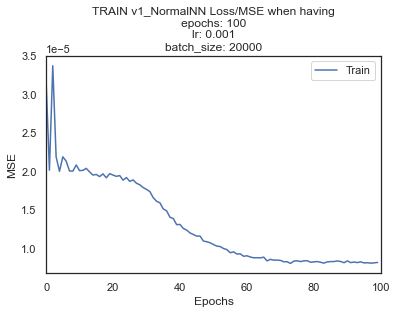

In [560]:
plt.plot(loss_values, linestyle='-', label='Train', color='C0');
plt.xlim(0, 100, 1);
plt.xlabel("Epochs");
plt.ylabel("MSE");
plt.title(f"TRAIN v1_NormalNN Loss/MSE when having\nepochs: {num_epochs}\nlr: {learning_rate}\nbatch_size: {batch_size}");
plt.legend();

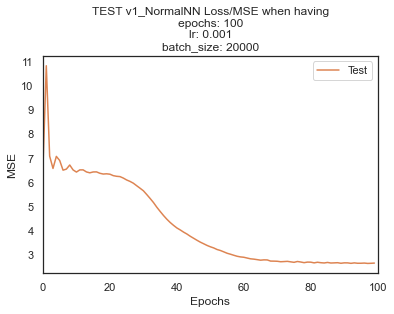

In [559]:
plt.plot(loss_values_test, linestyle='-', label='Test', color='C1');
plt.xlim(0, 100, 1);
plt.xlabel("Epochs");
plt.ylabel("MSE");
plt.title(f"TEST v1_NormalNN Loss/MSE when having\nepochs: {num_epochs}\nlr: {learning_rate}\nbatch_size: {batch_size}");
plt.legend();

In [557]:
print(f"""
TRAIN
    min  : {np.min(loss_values):2.8f}
    mean : {np.mean(loss_values):2.8f}
    max  : {np.max(loss_values):2.8f}
TEST
    min  : {np.min(loss_values_test):2.8f}
    mean : {np.mean(loss_values_test):2.8f}
    max  : {np.max(loss_values_test):2.8f}
""")


TRAIN
    min  : 0.00000809
    mean : 0.00001327
    max  : 0.00003377
TEST
    min  : 2.66170430
    mean : 4.24001741
    max  : 10.83005047



In [568]:
# Save model 
torch.save(model.state_dict(), PATH_TO_SAVE_MODELS_TO+'simpleNN.pkl')

In [572]:
torch.save(obj={
            'epoch': num_epochs,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss_func': loss_func,
            'loss_values_train': loss_values,
            'loss_values_test': loss_values_test,
            },
            f=PATH_TO_SAVE_MODELS_TO+'simpleNN_extensive.pkl')

In [573]:
model_load = torch.load(PATH_TO_SAVE_MODELS_TO+'simpleNN_extensive.pkl')
model_load

{'epoch': 100,
 'model_state_dict': OrderedDict([('cell_branch.0.weight',
               tensor([[ 0.0254,  0.0275, -0.0078,  ...,  0.0115, -0.0314,  0.0030],
                       [-0.0082, -0.0246, -0.0318,  ...,  0.0231, -0.0057,  0.0260],
                       [-0.0058, -0.0181, -0.0198,  ...,  0.0294,  0.0285, -0.0156],
                       ...,
                       [-0.0120, -0.0154, -0.0158,  ...,  0.0054, -0.0155,  0.0159],
                       [-0.0287,  0.0330,  0.0186,  ...,  0.0319, -0.0094,  0.0122],
                       [-0.0364,  0.0239,  0.0016,  ..., -0.0126, -0.0059, -0.0121]])),
              ('cell_branch.0.bias',
               tensor([-6.4251e-03, -4.3917e-03,  7.8201e-03,  2.2410e-02,  1.9945e-02,
                       -1.7462e-02, -5.7303e-03, -3.2234e-03, -2.7765e-02, -1.6945e-02,
                        2.8574e-02,  1.9936e-02, -2.3944e-02,  1.5986e-03,  4.7320e-03,
                       -2.8071e-02,  2.3325e-02, -5.8056e-04, -8.6648e-03, -2.8837e-

In [569]:
# load model for testing purposes.
model_load = torch.load(PATH_TO_SAVE_MODELS_TO+'simpleNN.pkl')

In [571]:
model.state_dict

<bound method Module.state_dict of Model(
  (cell_branch): Sequential(
    (0): Linear(in_features=908, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
  )
  (drug_branch): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
  )
  (fcn): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=1, bias=True)
    (3): ReLU()
  )
)>

In [570]:
model_load

OrderedDict([('cell_branch.0.weight',
              tensor([[ 0.0254,  0.0275, -0.0078,  ...,  0.0115, -0.0314,  0.0030],
                      [-0.0082, -0.0246, -0.0318,  ...,  0.0231, -0.0057,  0.0260],
                      [-0.0058, -0.0181, -0.0198,  ...,  0.0294,  0.0285, -0.0156],
                      ...,
                      [-0.0120, -0.0154, -0.0158,  ...,  0.0054, -0.0155,  0.0159],
                      [-0.0287,  0.0330,  0.0186,  ...,  0.0319, -0.0094,  0.0122],
                      [-0.0364,  0.0239,  0.0016,  ..., -0.0126, -0.0059, -0.0121]])),
             ('cell_branch.0.bias',
              tensor([-6.4251e-03, -4.3917e-03,  7.8201e-03,  2.2410e-02,  1.9945e-02,
                      -1.7462e-02, -5.7303e-03, -3.2234e-03, -2.7765e-02, -1.6945e-02,
                       2.8574e-02,  1.9936e-02, -2.3944e-02,  1.5986e-03,  4.7320e-03,
                      -2.8071e-02,  2.3325e-02, -5.8056e-04, -8.6648e-03, -2.8837e-02,
                       2.8342e-03, -1.4823e-

__CONCLUSION__: 
- The model is highly overfitted
  - While the train set has loss values of far below 1, the test set has values highly over 1

In [536]:
len(loss_values)

100

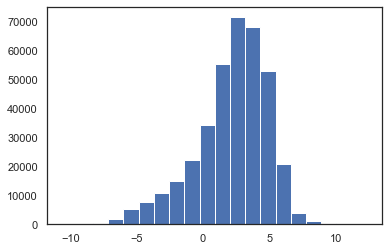

In [387]:
plt.hist(modeling_dataset.LN_IC50, bins=20);

---

## Model2 | Prevent Overfitting

- __Early Stopping__ doesn't make too much sense here (yet).
- __Dropout__ could prevent overfitting here and therefore be tried.
- 

In [ ]:
# ---------------- # 
# HYPER-PARAMETERS #
# ---------------- #
input_size   = 910 # which is gene_expr_base.shape[0]-1 = 911 - 1
                   # One value per feature
hidden_size   = 100
num_classes   = 1
num_epochs    = 100
batch_size    = 20_000
learning_rate = 0.001  

# ---------------------------- #
# CREATE TRAIN & TEST DATASETS #
# ---------------------------- #
train_loader = torch.utils.data.DataLoader(dataset     = train_set, 
                                           batch_size  = batch_size, 
                                           shuffle     = True,
                                           num_workers = 0)

test_loader = torch.utils.data.DataLoader(dataset     = test_set, 
                                          batch_size  = batch_size, 
                                          shuffle     = True,
                                          num_workers = 0)

In [1]:
%load_ext autoreload
%autoreload 24
from v1_NormalNN            import Model2
from my_utils.model_helpers import train_and_test_model

torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

# ---------- #
# INITIALIZE #
# ---------- #
model2 = Model2().to(device)
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(params=model2.parameters(), lr=learning_rate)

# ---------------- #
# TRAIN & EVALUATE #
# ---------------- #
model2, loss_values2, loss_values_test2 = train_and_test_model(
    modeling_dataset = modeling_dataset,
    model            = model2,
    criterion        = loss_func,
    optimizer        = optimizer,
    num_epochs       = 100,
    device           = device,
    train_loader     = train_loader,
    test_loader      = test_loader
)

NameError: name 'torch' is not defined

In [41]:
%load_ext autoreload
%autoreload 24
from v1_NormalNN            import Model2
from my_utils.model_helpers import train_and_test_model

torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

# ---------- #
# INITIALIZE #
# ---------- #
model2 = Model2().to(device)
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(params=model2.parameters(), lr=learning_rate)

# ---------------- #
# TRAIN & EVALUATE #
# ---------------- #
model2, loss_values2, loss_values_test2 = train_and_test_model(
    modeling_dataset = modeling_dataset,
    model            = model2,
    criterion        = loss_func,
    optimizer        = optimizer,
    num_epochs       = 100,
    device           = device,
    train_loader     = train_loader,
    test_loader      = test_loader
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Device: cpu


0it [00:03, ?it/s]


Epoch [1/100], Step [1/15], Loss: 11.9490
loss_values : 0.0000


4it [00:08,  2.06s/it]


MSE (test) : 9.08788013458252


0it [00:03, ?it/s]


Epoch [2/100], Step [1/15], Loss: 10.2247
loss_values : 0.0000


4it [00:07,  1.85s/it]


MSE (test) : 6.859049320220947


0it [00:02, ?it/s]


Epoch [3/100], Step [1/15], Loss: 7.7710
loss_values : 0.0000


4it [00:07,  1.98s/it]


MSE (test) : 7.738461017608643


0it [00:02, ?it/s]


Epoch [4/100], Step [1/15], Loss: 8.8150
loss_values : 0.0000


4it [00:08,  2.15s/it]


MSE (test) : 6.922532081604004


0it [00:03, ?it/s]


Epoch [5/100], Step [1/15], Loss: 7.7000
loss_values : 0.0000


4it [00:07,  1.94s/it]


MSE (test) : 6.455044746398926


0it [00:02, ?it/s]


Epoch [6/100], Step [1/15], Loss: 7.4615
loss_values : 0.0000


4it [00:08,  2.06s/it]


MSE (test) : 6.710602283477783


0it [00:02, ?it/s]


Epoch [7/100], Step [1/15], Loss: 7.4801
loss_values : 0.0000


4it [00:07,  1.84s/it]


MSE (test) : 6.853318691253662


0it [00:02, ?it/s]


Epoch [8/100], Step [1/15], Loss: 7.8259
loss_values : 0.0000


4it [00:07,  1.99s/it]


MSE (test) : 6.766324996948242


0it [00:02, ?it/s]


Epoch [9/100], Step [1/15], Loss: 7.7062
loss_values : 0.0000


4it [00:07,  2.00s/it]


MSE (test) : 6.547812461853027


0it [00:03, ?it/s]


Epoch [10/100], Step [1/15], Loss: 7.5130
loss_values : 0.0000


4it [00:08,  2.15s/it]


MSE (test) : 6.44213342666626


0it [00:03, ?it/s]


Epoch [11/100], Step [1/15], Loss: 7.4727
loss_values : 0.0000


4it [00:08,  2.01s/it]


MSE (test) : 6.571996212005615


0it [00:02, ?it/s]


Epoch [12/100], Step [1/15], Loss: 7.4218
loss_values : 0.0000


4it [00:08,  2.01s/it]


MSE (test) : 6.6583757400512695


0it [00:02, ?it/s]


Epoch [13/100], Step [1/15], Loss: 7.5494
loss_values : 0.0000


4it [00:08,  2.08s/it]


MSE (test) : 6.5241265296936035


0it [00:02, ?it/s]


Epoch [14/100], Step [1/15], Loss: 7.3587
loss_values : 0.0000


4it [00:08,  2.02s/it]


MSE (test) : 6.427931308746338


0it [00:02, ?it/s]


Epoch [15/100], Step [1/15], Loss: 7.4500
loss_values : 0.0000


4it [00:08,  2.15s/it]


MSE (test) : 6.464662551879883


0it [00:02, ?it/s]


Epoch [16/100], Step [1/15], Loss: 7.3644
loss_values : 0.0000


4it [00:08,  2.01s/it]


MSE (test) : 6.529887676239014


0it [00:02, ?it/s]


Epoch [17/100], Step [1/15], Loss: 7.3573
loss_values : 0.0000


4it [00:08,  2.03s/it]


MSE (test) : 6.5340728759765625


0it [00:02, ?it/s]


Epoch [18/100], Step [1/15], Loss: 7.4635
loss_values : 0.0000


4it [00:08,  2.05s/it]


MSE (test) : 6.471754550933838


0it [00:03, ?it/s]


Epoch [19/100], Step [1/15], Loss: 7.3106
loss_values : 0.0000


4it [00:08,  2.16s/it]


MSE (test) : 6.40431547164917


0it [00:03, ?it/s]


Epoch [20/100], Step [1/15], Loss: 7.3539
loss_values : 0.0000


4it [00:08,  2.10s/it]


MSE (test) : 6.396023750305176


0it [00:02, ?it/s]


Epoch [21/100], Step [1/15], Loss: 7.2647
loss_values : 0.0000


4it [00:08,  2.13s/it]


MSE (test) : 6.439419269561768


0it [00:03, ?it/s]


Epoch [22/100], Step [1/15], Loss: 7.3669
loss_values : 0.0000


4it [00:08,  2.12s/it]


MSE (test) : 6.434739589691162


0it [00:02, ?it/s]


Epoch [23/100], Step [1/15], Loss: 7.3123
loss_values : 0.0000


4it [00:08,  2.13s/it]


MSE (test) : 6.371419906616211


0it [00:03, ?it/s]


Epoch [24/100], Step [1/15], Loss: 7.2805
loss_values : 0.0000


4it [00:08,  2.12s/it]


MSE (test) : 6.323003768920898


0it [00:03, ?it/s]


Epoch [25/100], Step [1/15], Loss: 7.1146
loss_values : 0.0000


4it [00:08,  2.13s/it]


MSE (test) : 6.313403606414795


0it [00:03, ?it/s]


Epoch [26/100], Step [1/15], Loss: 6.9222
loss_values : 0.0000


4it [00:08,  2.15s/it]


MSE (test) : 6.301754474639893


0it [00:02, ?it/s]


Epoch [27/100], Step [1/15], Loss: 7.0878
loss_values : 0.0000


4it [00:08,  2.11s/it]


MSE (test) : 6.258281707763672


0it [00:03, ?it/s]


Epoch [28/100], Step [1/15], Loss: 7.1327
loss_values : 0.0000


4it [00:08,  2.16s/it]


MSE (test) : 6.197848320007324


0it [00:03, ?it/s]


Epoch [29/100], Step [1/15], Loss: 7.0605
loss_values : 0.0000


4it [00:08,  2.14s/it]


MSE (test) : 6.149116516113281


0it [00:03, ?it/s]


Epoch [30/100], Step [1/15], Loss: 7.0476
loss_values : 0.0000


4it [00:08,  2.18s/it]


MSE (test) : 6.111558437347412


0it [00:03, ?it/s]


Epoch [31/100], Step [1/15], Loss: 6.8739
loss_values : 0.0000


4it [00:06,  1.62s/it]


MSE (test) : 6.047173500061035


0it [00:03, ?it/s]


Epoch [32/100], Step [1/15], Loss: 6.9450
loss_values : 0.0000


4it [00:08,  2.20s/it]


MSE (test) : 5.947200775146484


0it [00:03, ?it/s]


Epoch [33/100], Step [1/15], Loss: 6.8218
loss_values : 0.0000


4it [00:08,  2.20s/it]


MSE (test) : 5.8490071296691895


0it [00:02, ?it/s]


Epoch [34/100], Step [1/15], Loss: 6.7307
loss_values : 0.0000


4it [00:08,  2.16s/it]


MSE (test) : 5.752740859985352


0it [00:02, ?it/s]


Epoch [35/100], Step [1/15], Loss: 6.5803
loss_values : 0.0000


4it [00:08,  2.08s/it]


MSE (test) : 5.637416362762451


0it [00:03, ?it/s]


Epoch [36/100], Step [1/15], Loss: 6.4498
loss_values : 0.0000


4it [00:08,  2.19s/it]


MSE (test) : 5.489932060241699


0it [00:03, ?it/s]


Epoch [37/100], Step [1/15], Loss: 6.2193
loss_values : 0.0000


4it [00:08,  2.22s/it]


MSE (test) : 5.347225189208984


0it [00:02, ?it/s]


Epoch [38/100], Step [1/15], Loss: 6.0876
loss_values : 0.0000


4it [00:08,  2.12s/it]


MSE (test) : 5.208307266235352


0it [00:02, ?it/s]


Epoch [39/100], Step [1/15], Loss: 5.7433
loss_values : 0.0000


4it [00:08,  2.16s/it]


MSE (test) : 5.036365985870361


0it [00:03, ?it/s]


Epoch [40/100], Step [1/15], Loss: 5.7506
loss_values : 0.0000


4it [00:08,  2.17s/it]


MSE (test) : 4.852613925933838


0it [00:02, ?it/s]


Epoch [41/100], Step [1/15], Loss: 5.5409
loss_values : 0.0000


4it [00:08,  2.14s/it]


MSE (test) : 4.6880903244018555


0it [00:02, ?it/s]


Epoch [42/100], Step [1/15], Loss: 5.2791
loss_values : 0.0000


4it [00:08,  2.16s/it]


MSE (test) : 4.52377462387085


0it [00:03, ?it/s]


Epoch [43/100], Step [1/15], Loss: 5.0999
loss_values : 0.0000


4it [00:08,  2.23s/it]


MSE (test) : 4.383206367492676


0it [00:03, ?it/s]


Epoch [44/100], Step [1/15], Loss: 5.0478
loss_values : 0.0000


4it [00:09,  2.28s/it]


MSE (test) : 4.259588718414307


0it [00:03, ?it/s]


Epoch [45/100], Step [1/15], Loss: 4.8310
loss_values : 0.0000


4it [00:08,  2.24s/it]


MSE (test) : 4.15038537979126


0it [00:03, ?it/s]


Epoch [46/100], Step [1/15], Loss: 4.7435
loss_values : 0.0000


4it [00:09,  2.33s/it]


MSE (test) : 4.0607523918151855


0it [00:03, ?it/s]


Epoch [47/100], Step [1/15], Loss: 4.6475
loss_values : 0.0000


4it [00:09,  2.34s/it]


MSE (test) : 3.971338987350464


0it [00:03, ?it/s]


Epoch [48/100], Step [1/15], Loss: 4.5132
loss_values : 0.0000


4it [00:09,  2.29s/it]


MSE (test) : 3.88535737991333


0it [00:03, ?it/s]


Epoch [49/100], Step [1/15], Loss: 4.4543
loss_values : 0.0000


4it [00:09,  2.28s/it]


MSE (test) : 3.786860227584839


0it [00:03, ?it/s]


Epoch [50/100], Step [1/15], Loss: 4.2995
loss_values : 0.0000


4it [00:09,  2.31s/it]


MSE (test) : 3.6934657096862793


0it [00:03, ?it/s]


Epoch [51/100], Step [1/15], Loss: 4.2877
loss_values : 0.0000


4it [00:09,  2.26s/it]


MSE (test) : 3.6050543785095215


0it [00:02, ?it/s]


Epoch [52/100], Step [1/15], Loss: 4.0884
loss_values : 0.0000


4it [00:08,  2.22s/it]


MSE (test) : 3.532244920730591


0it [00:03, ?it/s]


Epoch [53/100], Step [1/15], Loss: 3.9987
loss_values : 0.0000


4it [00:08,  2.25s/it]


MSE (test) : 3.4693944454193115


0it [00:02, ?it/s]


Epoch [54/100], Step [1/15], Loss: 3.9394
loss_values : 0.0000


4it [00:07,  1.87s/it]


MSE (test) : 3.4113516807556152


0it [00:02, ?it/s]


Epoch [55/100], Step [1/15], Loss: 3.7860
loss_values : 0.0000


4it [00:08,  2.10s/it]


MSE (test) : 3.358644485473633


0it [00:03, ?it/s]


Epoch [56/100], Step [1/15], Loss: 3.8139
loss_values : 0.0000


4it [00:07,  1.99s/it]


MSE (test) : 3.2946231365203857


0it [00:02, ?it/s]


Epoch [57/100], Step [1/15], Loss: 3.7194
loss_values : 0.0000


4it [00:08,  2.02s/it]


MSE (test) : 3.2427334785461426


0it [00:02, ?it/s]


Epoch [58/100], Step [1/15], Loss: 3.7624
loss_values : 0.0000


4it [00:08,  2.12s/it]


MSE (test) : 3.193831205368042


0it [00:03, ?it/s]


Epoch [59/100], Step [1/15], Loss: 3.6112
loss_values : 0.0000


4it [00:08,  2.11s/it]


MSE (test) : 3.149132013320923


0it [00:03, ?it/s]


Epoch [60/100], Step [1/15], Loss: 3.5659
loss_values : 0.0000


4it [00:08,  2.13s/it]


MSE (test) : 3.1088531017303467


0it [00:03, ?it/s]


Epoch [61/100], Step [1/15], Loss: 3.5844
loss_values : 0.0000


4it [00:08,  2.10s/it]


MSE (test) : 3.065904378890991


0it [00:02, ?it/s]


Epoch [62/100], Step [1/15], Loss: 3.4968
loss_values : 0.0000


4it [00:08,  2.10s/it]


MSE (test) : 3.0278801918029785


0it [00:03, ?it/s]


Epoch [63/100], Step [1/15], Loss: 3.4340
loss_values : 0.0000


4it [00:08,  2.17s/it]


MSE (test) : 3.011573553085327


0it [00:02, ?it/s]


Epoch [64/100], Step [1/15], Loss: 3.5048
loss_values : 0.0000


4it [00:08,  2.22s/it]


MSE (test) : 2.9755592346191406


0it [00:02, ?it/s]


Epoch [65/100], Step [1/15], Loss: 3.3756
loss_values : 0.0000


4it [00:08,  2.10s/it]


MSE (test) : 2.930774688720703


0it [00:02, ?it/s]


Epoch [66/100], Step [1/15], Loss: 3.3913
loss_values : 0.0000


4it [00:08,  2.11s/it]


MSE (test) : 2.913221836090088


0it [00:03, ?it/s]


Epoch [67/100], Step [1/15], Loss: 3.3849
loss_values : 0.0000


4it [00:08,  2.10s/it]


MSE (test) : 2.899282693862915


0it [00:02, ?it/s]


Epoch [68/100], Step [1/15], Loss: 3.2475
loss_values : 0.0000


4it [00:08,  2.07s/it]


MSE (test) : 2.861142635345459


0it [00:03, ?it/s]


Epoch [69/100], Step [1/15], Loss: 3.2241
loss_values : 0.0000


4it [00:08,  2.17s/it]


MSE (test) : 2.8542516231536865


0it [00:03, ?it/s]


Epoch [70/100], Step [1/15], Loss: 3.1930
loss_values : 0.0000


4it [00:08,  2.11s/it]


MSE (test) : 2.825603485107422


0it [00:02, ?it/s]


Epoch [71/100], Step [1/15], Loss: 3.2314
loss_values : 0.0000


4it [00:08,  2.07s/it]


MSE (test) : 2.8212838172912598


0it [00:03, ?it/s]


Epoch [72/100], Step [1/15], Loss: 3.1907
loss_values : 0.0000


4it [00:08,  2.21s/it]


MSE (test) : 2.8115758895874023


0it [00:02, ?it/s]


Epoch [73/100], Step [1/15], Loss: 3.2195
loss_values : 0.0000


4it [00:08,  2.04s/it]


MSE (test) : 2.7841672897338867


0it [00:02, ?it/s]


Epoch [74/100], Step [1/15], Loss: 3.1934
loss_values : 0.0000


4it [00:08,  2.10s/it]


MSE (test) : 2.7891597747802734


0it [00:02, ?it/s]


Epoch [75/100], Step [1/15], Loss: 3.1252
loss_values : 0.0000


4it [00:08,  2.13s/it]


MSE (test) : 2.7647061347961426


0it [00:02, ?it/s]


Epoch [76/100], Step [1/15], Loss: 3.1597
loss_values : 0.0000


4it [00:07,  1.97s/it]


MSE (test) : 2.7582645416259766


0it [00:02, ?it/s]


Epoch [77/100], Step [1/15], Loss: 3.1394
loss_values : 0.0000


4it [00:08,  2.10s/it]


MSE (test) : 2.7517616748809814


0it [00:02, ?it/s]


Epoch [78/100], Step [1/15], Loss: 3.2344
loss_values : 0.0000


4it [00:07,  1.97s/it]


MSE (test) : 2.735851287841797


0it [00:02, ?it/s]


Epoch [79/100], Step [1/15], Loss: 3.0674
loss_values : 0.0000


4it [00:07,  1.83s/it]


MSE (test) : 2.739973306655884


0it [00:03, ?it/s]


Epoch [80/100], Step [1/15], Loss: 3.0987
loss_values : 0.0000


4it [00:08,  2.21s/it]


MSE (test) : 2.7442541122436523


0it [00:02, ?it/s]


Epoch [81/100], Step [1/15], Loss: 3.1123
loss_values : 0.0000


4it [00:08,  2.01s/it]


MSE (test) : 2.7244961261749268


0it [00:03, ?it/s]


Epoch [82/100], Step [1/15], Loss: 3.0792
loss_values : 0.0000


4it [00:08,  2.07s/it]


MSE (test) : 2.7139482498168945


0it [00:02, ?it/s]


Epoch [83/100], Step [1/15], Loss: 3.0405
loss_values : 0.0000


4it [00:08,  2.11s/it]


MSE (test) : 2.7261552810668945


0it [00:02, ?it/s]


Epoch [84/100], Step [1/15], Loss: 3.0852
loss_values : 0.0000


4it [00:08,  2.16s/it]


MSE (test) : 2.715221405029297


0it [00:02, ?it/s]


Epoch [85/100], Step [1/15], Loss: 3.1257
loss_values : 0.0000


4it [00:08,  2.06s/it]


MSE (test) : 2.704192876815796


0it [00:03, ?it/s]


Epoch [86/100], Step [1/15], Loss: 3.0396
loss_values : 0.0000


4it [00:08,  2.02s/it]


MSE (test) : 2.728513240814209


0it [00:02, ?it/s]


Epoch [87/100], Step [1/15], Loss: 3.1589
loss_values : 0.0000


4it [00:08,  2.03s/it]


MSE (test) : 2.7270069122314453


0it [00:03, ?it/s]


Epoch [88/100], Step [1/15], Loss: 3.0880
loss_values : 0.0000


4it [00:08,  2.06s/it]


MSE (test) : 2.6943740844726562


0it [00:03, ?it/s]


Epoch [89/100], Step [1/15], Loss: 3.0300
loss_values : 0.0000


4it [00:07,  1.99s/it]


MSE (test) : 2.7184062004089355


0it [00:02, ?it/s]


Epoch [90/100], Step [1/15], Loss: 3.0818
loss_values : 0.0000


4it [00:07,  1.99s/it]


MSE (test) : 2.712409019470215


0it [00:03, ?it/s]


Epoch [91/100], Step [1/15], Loss: 3.0908
loss_values : 0.0000


4it [00:08,  2.02s/it]


MSE (test) : 2.687082052230835


0it [00:02, ?it/s]


Epoch [92/100], Step [1/15], Loss: 3.1002
loss_values : 0.0000


4it [00:08,  2.10s/it]


MSE (test) : 2.713829517364502


0it [00:02, ?it/s]


Epoch [93/100], Step [1/15], Loss: 3.0782
loss_values : 0.0000


4it [00:07,  1.97s/it]


MSE (test) : 2.7069084644317627


0it [00:02, ?it/s]


Epoch [94/100], Step [1/15], Loss: 3.0761
loss_values : 0.0000


4it [00:07,  1.95s/it]


MSE (test) : 2.6792047023773193


0it [00:02, ?it/s]


Epoch [95/100], Step [1/15], Loss: 2.9970
loss_values : 0.0000


4it [00:07,  1.97s/it]


MSE (test) : 2.7090165615081787


0it [00:02, ?it/s]


Epoch [96/100], Step [1/15], Loss: 3.0854
loss_values : 0.0000


4it [00:08,  2.01s/it]


MSE (test) : 2.697908639907837


0it [00:02, ?it/s]


Epoch [97/100], Step [1/15], Loss: 3.1153
loss_values : 0.0000


4it [00:07,  1.84s/it]


MSE (test) : 2.6771481037139893


0it [00:02, ?it/s]


Epoch [98/100], Step [1/15], Loss: 3.0443
loss_values : 0.0000


4it [00:07,  1.97s/it]


MSE (test) : 2.71835994720459


0it [00:02, ?it/s]


Epoch [99/100], Step [1/15], Loss: 3.1335
loss_values : 0.0000


4it [00:07,  1.90s/it]


MSE (test) : 2.679351806640625


0it [00:02, ?it/s]


Epoch [100/100], Step [1/15], Loss: 3.0494
loss_values : 0.0000


4it [00:07,  1.93s/it]


MSE (test) : 2.6779227256774902



TRAIN
    min  : 2.99702096
    mean : 5.08477860
    max  : 11.94902706
    sd   : 2.03453841
TEST
    min  : 2.67714810
    mean : 4.39381170
    max  : 9.08788013
    sd   : 1.69702971



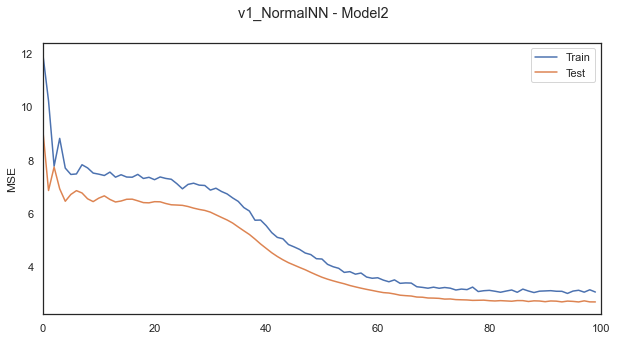

In [55]:
from matplotlib.ticker import FormatStrFormatter

plt.rcParams["figure.figsize"] = (10, 5)

loss_values2_backcalculated = [loss_v * len(modeling_dataset) for loss_v in loss_values2]

fig, axs = plt.subplots(1)
fig.suptitle("v1_NormalNN - Model2");

axs.plot(loss_values2_backcalculated, linestyle='-', label='Train', color='C0'); # Train
axs.plot(loss_values_test2, linestyle='-', label='Test', color='C1'); # Test
axs.legend();
axs.ticklabel_format(style='plain');
axs.set_xlim(0, num_epochs, 1);
axs.set_ylabel("MSE");

print(f"""
TRAIN
    min  : {np.min(loss_values2_backcalculated):2.8f}
    mean : {np.mean(loss_values2_backcalculated):2.8f}
    max  : {np.max(loss_values2_backcalculated):2.8f}
    sd   : {np.std(loss_values2_backcalculated):2.8f}
TEST
    min  : {np.min(loss_values_test2):2.8f}
    mean : {np.mean(loss_values_test2):2.8f}
    max  : {np.max(loss_values_test2):2.8f}
    sd   : {np.std(loss_values_test2):2.8f}
""")

---

## Model3 | Use [DeepCDR](http://liuqiao.me/files/DeepCDR.pdf)'s gene epxression network structure | Prevent Overfitting

- __Early Stopping__ doesn't make too much sense here (yet).
- __Dropout__ could prevent overfitting here and therefore be tried.
- 

In [35]:
%load_ext autoreload
%autoreload 24
from v1_NormalNN            import Model3
from my_utils.model_helpers import train_and_test_model

# ------------------------------------------------------------- #
# What has been done differently for this model? 
# - zero_grad() was set to the BEGINNING of the batch for-loop.
# ------------------------------------------------------------- #

torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

# ---------- #
# INITIALIZE #
# ---------- #
model4 = Model3().to(device)
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(params=model4.parameters(), lr=learning_rate)

# ---------------- #
# TRAIN & EVALUATE #
# ---------------- #
model4, loss_values4, loss_values_test4 = train_and_test_model(
    modeling_dataset = modeling_dataset,
    model            = model4,
    criterion        = loss_func,
    optimizer        = optimizer,
    num_epochs       = 100,
    device           = device,
    train_loader     = train_loader,
    test_loader      = test_loader
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Device: cpu


0it [00:02, ?it/s]


Epoch [1/100], Step [1/15], Loss: 11.5421
loss_values : 0.0000


4it [00:07,  1.80s/it]


MSE (test) : 9.293899536132812


0it [00:02, ?it/s]


Epoch [2/100], Step [1/15], Loss: 10.5030
loss_values : 0.0000


4it [00:06,  1.65s/it]


MSE (test) : 8.572824478149414


0it [00:02, ?it/s]


Epoch [3/100], Step [1/15], Loss: 9.8105
loss_values : 0.0000


4it [00:07,  1.94s/it]


MSE (test) : 7.930991172790527


0it [00:02, ?it/s]


Epoch [4/100], Step [1/15], Loss: 8.9363
loss_values : 0.0000


4it [00:07,  1.80s/it]


MSE (test) : 7.310850620269775


0it [00:02, ?it/s]


Epoch [5/100], Step [1/15], Loss: 8.3822
loss_values : 0.0000


4it [00:05,  1.46s/it]


MSE (test) : 6.762743949890137


0it [00:02, ?it/s]


Epoch [6/100], Step [1/15], Loss: 7.6385
loss_values : 0.0000


4it [00:07,  1.87s/it]


MSE (test) : 6.495481014251709


0it [00:02, ?it/s]


Epoch [7/100], Step [1/15], Loss: 7.3898
loss_values : 0.0000


4it [00:07,  1.81s/it]


MSE (test) : 6.66557502746582


0it [00:02, ?it/s]


Epoch [8/100], Step [1/15], Loss: 7.6045
loss_values : 0.0000


4it [00:08,  2.01s/it]


MSE (test) : 6.952034950256348


0it [00:02, ?it/s]


Epoch [9/100], Step [1/15], Loss: 8.0335
loss_values : 0.0000


4it [00:07,  1.88s/it]


MSE (test) : 6.971508502960205


0it [00:02, ?it/s]


Epoch [10/100], Step [1/15], Loss: 7.9816
loss_values : 0.0000


4it [00:07,  1.82s/it]


MSE (test) : 6.788897514343262


0it [00:02, ?it/s]


Epoch [11/100], Step [1/15], Loss: 7.6551
loss_values : 0.0000


4it [00:07,  1.91s/it]


MSE (test) : 6.590264797210693


0it [00:02, ?it/s]


Epoch [12/100], Step [1/15], Loss: 7.3919
loss_values : 0.0000


4it [00:07,  1.85s/it]


MSE (test) : 6.476975440979004


0it [00:02, ?it/s]


Epoch [13/100], Step [1/15], Loss: 7.3231
loss_values : 0.0000


4it [00:07,  1.90s/it]


MSE (test) : 6.456333637237549


0it [00:02, ?it/s]


Epoch [14/100], Step [1/15], Loss: 7.2698
loss_values : 0.0000


4it [00:07,  1.90s/it]


MSE (test) : 6.492059230804443


0it [00:02, ?it/s]


Epoch [15/100], Step [1/15], Loss: 7.3410
loss_values : 0.0000


4it [00:07,  1.83s/it]


MSE (test) : 6.541934013366699


0it [00:02, ?it/s]


Epoch [16/100], Step [1/15], Loss: 7.4759
loss_values : 0.0000


4it [00:07,  1.91s/it]


MSE (test) : 6.576998233795166


0it [00:02, ?it/s]


Epoch [17/100], Step [1/15], Loss: 7.6163
loss_values : 0.0000


4it [00:07,  1.90s/it]


MSE (test) : 6.583370208740234


0it [00:02, ?it/s]


Epoch [18/100], Step [1/15], Loss: 7.6597
loss_values : 0.0000


4it [00:07,  1.87s/it]


MSE (test) : 6.562114715576172


0it [00:02, ?it/s]


Epoch [19/100], Step [1/15], Loss: 7.5151
loss_values : 0.0000


4it [00:07,  1.90s/it]


MSE (test) : 6.521878719329834


0it [00:02, ?it/s]


Epoch [20/100], Step [1/15], Loss: 7.3098
loss_values : 0.0000


4it [00:07,  1.92s/it]


MSE (test) : 6.473538398742676


0it [00:02, ?it/s]


Epoch [21/100], Step [1/15], Loss: 7.3295
loss_values : 0.0000


4it [00:07,  1.85s/it]


MSE (test) : 6.431726932525635


0it [00:02, ?it/s]


Epoch [22/100], Step [1/15], Loss: 7.1960
loss_values : 0.0000


4it [00:07,  1.78s/it]


MSE (test) : 6.408158779144287


0it [00:02, ?it/s]


Epoch [23/100], Step [1/15], Loss: 7.2615
loss_values : 0.0000


4it [00:07,  1.88s/it]


MSE (test) : 6.408730983734131


0it [00:02, ?it/s]


Epoch [24/100], Step [1/15], Loss: 7.1644
loss_values : 0.0000


4it [00:07,  1.81s/it]


MSE (test) : 6.425826549530029


0it [00:02, ?it/s]


Epoch [25/100], Step [1/15], Loss: 7.3249
loss_values : 0.0000


4it [00:07,  1.87s/it]


MSE (test) : 6.439916133880615


0it [00:02, ?it/s]


Epoch [26/100], Step [1/15], Loss: 7.3524
loss_values : 0.0000


4it [00:07,  1.78s/it]


MSE (test) : 6.43044900894165


0it [00:02, ?it/s]


Epoch [27/100], Step [1/15], Loss: 7.3831
loss_values : 0.0000


4it [00:07,  1.78s/it]


MSE (test) : 6.394568920135498


0it [00:02, ?it/s]


Epoch [28/100], Step [1/15], Loss: 7.1962
loss_values : 0.0000


4it [00:06,  1.74s/it]


MSE (test) : 6.344240665435791


0it [00:02, ?it/s]


Epoch [29/100], Step [1/15], Loss: 7.2164
loss_values : 0.0000


4it [00:07,  1.85s/it]


MSE (test) : 6.2945709228515625


0it [00:02, ?it/s]


Epoch [30/100], Step [1/15], Loss: 7.2220
loss_values : 0.0000


4it [00:07,  1.77s/it]


MSE (test) : 6.251980304718018


0it [00:02, ?it/s]


Epoch [31/100], Step [1/15], Loss: 7.0613
loss_values : 0.0000


4it [00:06,  1.57s/it]


MSE (test) : 6.2137603759765625


0it [00:02, ?it/s]


Epoch [32/100], Step [1/15], Loss: 7.0748
loss_values : 0.0000


4it [00:07,  1.88s/it]


MSE (test) : 6.171444892883301


0it [00:02, ?it/s]


Epoch [33/100], Step [1/15], Loss: 6.8858
loss_values : 0.0000


4it [00:07,  1.88s/it]


MSE (test) : 6.115861415863037


0it [00:02, ?it/s]


Epoch [34/100], Step [1/15], Loss: 6.9361
loss_values : 0.0000


4it [00:07,  1.92s/it]


MSE (test) : 6.046177864074707


0it [00:02, ?it/s]


Epoch [35/100], Step [1/15], Loss: 6.9245
loss_values : 0.0000


4it [00:07,  1.89s/it]


MSE (test) : 5.967976093292236


0it [00:02, ?it/s]


Epoch [36/100], Step [1/15], Loss: 6.6723
loss_values : 0.0000


4it [00:07,  1.76s/it]


MSE (test) : 5.887294292449951


0it [00:02, ?it/s]


Epoch [37/100], Step [1/15], Loss: 6.6299
loss_values : 0.0000


4it [00:07,  1.80s/it]


MSE (test) : 5.805250644683838


0it [00:02, ?it/s]


Epoch [38/100], Step [1/15], Loss: 6.6555
loss_values : 0.0000


4it [00:07,  1.93s/it]


MSE (test) : 5.709066867828369


0it [00:02, ?it/s]


Epoch [39/100], Step [1/15], Loss: 6.4617
loss_values : 0.0000


4it [00:07,  2.00s/it]


MSE (test) : 5.591116428375244


0it [00:02, ?it/s]


Epoch [40/100], Step [1/15], Loss: 6.2922
loss_values : 0.0000


4it [00:07,  1.84s/it]


MSE (test) : 5.4618353843688965


0it [00:02, ?it/s]


Epoch [41/100], Step [1/15], Loss: 6.1741
loss_values : 0.0000


4it [00:07,  1.75s/it]


MSE (test) : 5.332169532775879


0it [00:02, ?it/s]


Epoch [42/100], Step [1/15], Loss: 6.0531
loss_values : 0.0000


4it [00:07,  1.92s/it]


MSE (test) : 5.2009100914001465


0it [00:02, ?it/s]


Epoch [43/100], Step [1/15], Loss: 5.8325
loss_values : 0.0000


4it [00:07,  1.90s/it]


MSE (test) : 5.059875965118408


0it [00:02, ?it/s]


Epoch [44/100], Step [1/15], Loss: 5.8505
loss_values : 0.0000


4it [00:07,  1.80s/it]


MSE (test) : 4.9128031730651855


0it [00:02, ?it/s]


Epoch [45/100], Step [1/15], Loss: 5.6797
loss_values : 0.0000


4it [00:07,  1.83s/it]


MSE (test) : 4.770208358764648


0it [00:02, ?it/s]


Epoch [46/100], Step [1/15], Loss: 5.4436
loss_values : 0.0000


4it [00:07,  1.87s/it]


MSE (test) : 4.631920337677002


0it [00:02, ?it/s]


Epoch [47/100], Step [1/15], Loss: 5.2077
loss_values : 0.0000


4it [00:07,  1.89s/it]


MSE (test) : 4.485494136810303


0it [00:02, ?it/s]


Epoch [48/100], Step [1/15], Loss: 5.0640
loss_values : 0.0000


4it [00:07,  1.86s/it]


MSE (test) : 4.341949462890625


0it [00:02, ?it/s]


Epoch [49/100], Step [1/15], Loss: 4.9221
loss_values : 0.0000


4it [00:07,  1.89s/it]


MSE (test) : 4.212766170501709


0it [00:02, ?it/s]


Epoch [50/100], Step [1/15], Loss: 4.7353
loss_values : 0.0000


4it [00:07,  1.96s/it]


MSE (test) : 4.078041076660156


0it [00:02, ?it/s]


Epoch [51/100], Step [1/15], Loss: 4.6490
loss_values : 0.0000


4it [00:06,  1.72s/it]


MSE (test) : 3.958545684814453


0it [00:02, ?it/s]


Epoch [52/100], Step [1/15], Loss: 4.5486
loss_values : 0.0000


4it [00:06,  1.70s/it]


MSE (test) : 3.847367286682129


0it [00:02, ?it/s]


Epoch [53/100], Step [1/15], Loss: 4.4139
loss_values : 0.0000


4it [00:06,  1.70s/it]


MSE (test) : 3.733994245529175


0it [00:02, ?it/s]


Epoch [54/100], Step [1/15], Loss: 4.2881
loss_values : 0.0000


4it [00:06,  1.71s/it]


MSE (test) : 3.642451524734497


0it [00:02, ?it/s]


Epoch [55/100], Step [1/15], Loss: 4.1794
loss_values : 0.0000


4it [00:06,  1.65s/it]


MSE (test) : 3.5438027381896973


0it [00:02, ?it/s]


Epoch [56/100], Step [1/15], Loss: 3.9864
loss_values : 0.0000


4it [00:06,  1.74s/it]


MSE (test) : 3.476475715637207


0it [00:02, ?it/s]


Epoch [57/100], Step [1/15], Loss: 3.9074
loss_values : 0.0000


4it [00:07,  1.81s/it]


MSE (test) : 3.394493818283081


0it [00:01, ?it/s]


Epoch [58/100], Step [1/15], Loss: 3.8294
loss_values : 0.0000


4it [00:05,  1.42s/it]


MSE (test) : 3.337541103363037


0it [00:02, ?it/s]


Epoch [59/100], Step [1/15], Loss: 3.8946
loss_values : 0.0000


4it [00:06,  1.71s/it]


MSE (test) : 3.2727584838867188


0it [00:02, ?it/s]


Epoch [60/100], Step [1/15], Loss: 3.6878
loss_values : 0.0000


4it [00:06,  1.69s/it]


MSE (test) : 3.214329957962036


0it [00:02, ?it/s]


Epoch [61/100], Step [1/15], Loss: 3.6703
loss_values : 0.0000


4it [00:07,  1.80s/it]


MSE (test) : 3.165757894515991


0it [00:02, ?it/s]


Epoch [62/100], Step [1/15], Loss: 3.5863
loss_values : 0.0000


4it [00:07,  1.78s/it]


MSE (test) : 3.116969108581543


0it [00:02, ?it/s]


Epoch [63/100], Step [1/15], Loss: 3.5571
loss_values : 0.0000


4it [00:07,  1.85s/it]


MSE (test) : 3.080660104751587


0it [00:02, ?it/s]


Epoch [64/100], Step [1/15], Loss: 3.4404
loss_values : 0.0000


4it [00:06,  1.73s/it]


MSE (test) : 3.039839029312134


0it [00:02, ?it/s]


Epoch [65/100], Step [1/15], Loss: 3.5992
loss_values : 0.0000


4it [00:07,  1.75s/it]


MSE (test) : 3.012650489807129


0it [00:02, ?it/s]


Epoch [66/100], Step [1/15], Loss: 3.4503
loss_values : 0.0000


4it [00:07,  1.78s/it]


MSE (test) : 2.986990213394165


0it [00:02, ?it/s]


Epoch [67/100], Step [1/15], Loss: 3.3595
loss_values : 0.0000


4it [00:06,  1.70s/it]


MSE (test) : 2.9619393348693848


0it [00:02, ?it/s]


Epoch [68/100], Step [1/15], Loss: 3.3627
loss_values : 0.0000


4it [00:07,  1.78s/it]


MSE (test) : 2.939812421798706


0it [00:02, ?it/s]


Epoch [69/100], Step [1/15], Loss: 3.2761
loss_values : 0.0000


4it [00:07,  1.80s/it]


MSE (test) : 2.9207732677459717


0it [00:02, ?it/s]


Epoch [70/100], Step [1/15], Loss: 3.4223
loss_values : 0.0000


4it [00:07,  1.83s/it]


MSE (test) : 2.9045512676239014


0it [00:02, ?it/s]


Epoch [71/100], Step [1/15], Loss: 3.3509
loss_values : 0.0000


4it [00:06,  1.74s/it]


MSE (test) : 2.8883864879608154


0it [00:02, ?it/s]


Epoch [72/100], Step [1/15], Loss: 3.2570
loss_values : 0.0000


4it [00:07,  1.77s/it]


MSE (test) : 2.8732542991638184


0it [00:02, ?it/s]


Epoch [73/100], Step [1/15], Loss: 3.2737
loss_values : 0.0000


4it [00:07,  1.79s/it]


MSE (test) : 2.860564947128296


0it [00:02, ?it/s]


Epoch [74/100], Step [1/15], Loss: 3.1876
loss_values : 0.0000


4it [00:07,  1.79s/it]


MSE (test) : 2.853248357772827


0it [00:02, ?it/s]


Epoch [75/100], Step [1/15], Loss: 3.2657
loss_values : 0.0000


4it [00:07,  1.79s/it]


MSE (test) : 2.843754291534424


0it [00:02, ?it/s]


Epoch [76/100], Step [1/15], Loss: 3.2371
loss_values : 0.0000


4it [00:06,  1.74s/it]


MSE (test) : 2.8345377445220947


0it [00:02, ?it/s]


Epoch [77/100], Step [1/15], Loss: 3.1106
loss_values : 0.0000


4it [00:06,  1.70s/it]


MSE (test) : 2.8325252532958984


0it [00:02, ?it/s]


Epoch [78/100], Step [1/15], Loss: 3.1973
loss_values : 0.0000


4it [00:07,  1.77s/it]


MSE (test) : 2.82308030128479


0it [00:02, ?it/s]


Epoch [79/100], Step [1/15], Loss: 3.1837
loss_values : 0.0000


4it [00:07,  1.82s/it]


MSE (test) : 2.8255927562713623


0it [00:02, ?it/s]


Epoch [80/100], Step [1/15], Loss: 3.1858
loss_values : 0.0000


4it [00:06,  1.71s/it]


MSE (test) : 2.8146543502807617


0it [00:02, ?it/s]


Epoch [81/100], Step [1/15], Loss: 3.1975
loss_values : 0.0000


4it [00:06,  1.69s/it]


MSE (test) : 2.8147075176239014


0it [00:02, ?it/s]


Epoch [82/100], Step [1/15], Loss: 3.1840
loss_values : 0.0000


4it [00:07,  1.79s/it]


MSE (test) : 2.8091917037963867


0it [00:02, ?it/s]


Epoch [83/100], Step [1/15], Loss: 3.1643
loss_values : 0.0000


4it [00:06,  1.75s/it]


MSE (test) : 2.8107476234436035


0it [00:02, ?it/s]


Epoch [84/100], Step [1/15], Loss: 3.2387
loss_values : 0.0000


4it [00:06,  1.74s/it]


MSE (test) : 2.8055903911590576


0it [00:02, ?it/s]


Epoch [85/100], Step [1/15], Loss: 3.2155
loss_values : 0.0000


4it [00:06,  1.75s/it]


MSE (test) : 2.8039793968200684


0it [00:01, ?it/s]


Epoch [86/100], Step [1/15], Loss: 3.2004
loss_values : 0.0000


4it [00:06,  1.59s/it]


MSE (test) : 2.801630735397339


0it [00:02, ?it/s]


Epoch [87/100], Step [1/15], Loss: 3.1968
loss_values : 0.0000


4it [00:07,  1.77s/it]


MSE (test) : 2.8023362159729004


0it [00:02, ?it/s]


Epoch [88/100], Step [1/15], Loss: 3.2070
loss_values : 0.0000


4it [00:07,  1.77s/it]


MSE (test) : 2.795959949493408


0it [00:02, ?it/s]


Epoch [89/100], Step [1/15], Loss: 3.1814
loss_values : 0.0000


4it [00:07,  1.86s/it]


MSE (test) : 2.799940586090088


0it [00:02, ?it/s]


Epoch [90/100], Step [1/15], Loss: 3.2653
loss_values : 0.0000


4it [00:06,  1.74s/it]


MSE (test) : 2.7929811477661133


0it [00:02, ?it/s]


Epoch [91/100], Step [1/15], Loss: 3.1811
loss_values : 0.0000


4it [00:06,  1.70s/it]


MSE (test) : 2.7973790168762207


0it [00:02, ?it/s]


Epoch [92/100], Step [1/15], Loss: 3.2836
loss_values : 0.0000


4it [00:06,  1.66s/it]


MSE (test) : 2.789349317550659


0it [00:02, ?it/s]


Epoch [93/100], Step [1/15], Loss: 3.1530
loss_values : 0.0000


4it [00:07,  1.79s/it]


MSE (test) : 2.7994422912597656


0it [00:02, ?it/s]


Epoch [94/100], Step [1/15], Loss: 3.1435
loss_values : 0.0000


4it [00:07,  1.86s/it]


MSE (test) : 2.787470579147339


0it [00:02, ?it/s]


Epoch [95/100], Step [1/15], Loss: 3.1785
loss_values : 0.0000


4it [00:06,  1.66s/it]


MSE (test) : 2.7925784587860107


0it [00:02, ?it/s]


Epoch [96/100], Step [1/15], Loss: 3.2414
loss_values : 0.0000


4it [00:07,  1.82s/it]


MSE (test) : 2.787529230117798


0it [00:02, ?it/s]


Epoch [97/100], Step [1/15], Loss: 3.2348
loss_values : 0.0000


4it [00:06,  1.74s/it]


MSE (test) : 2.7874701023101807


0it [00:02, ?it/s]


Epoch [98/100], Step [1/15], Loss: 3.1858
loss_values : 0.0000


4it [00:06,  1.70s/it]


MSE (test) : 2.7861993312835693


0it [00:02, ?it/s]


Epoch [99/100], Step [1/15], Loss: 3.1437
loss_values : 0.0000


4it [00:07,  1.83s/it]


MSE (test) : 2.7865116596221924


0it [00:02, ?it/s]


Epoch [100/100], Step [1/15], Loss: 3.1912
loss_values : 0.0000


4it [00:07,  1.79s/it]


MSE (test) : 2.7846856117248535



TRAIN
    min  : 3.11064649
    mean : 5.29928780
    max  : 11.54205418
    sd   : 2.06912605
TEST
    min  : 2.78468561
    mean : 4.58783340
    max  : 9.29389954
    sd   : 1.74848282




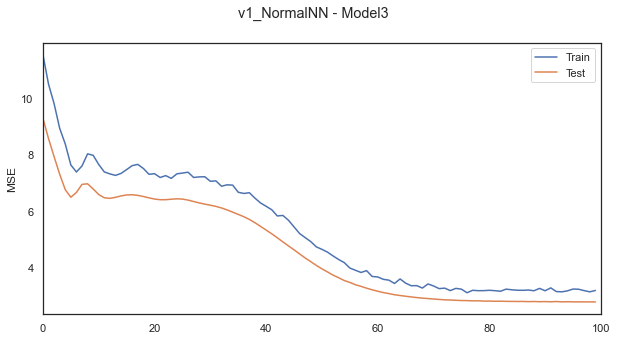

In [53]:
from matplotlib.ticker import FormatStrFormatter

model3 = copy.deepcopy(model4)
loss_values3 = copy.deepcopy(loss_values4)
loss_values_test3 = copy.deepcopy(loss_values_test4)

plt.rcParams["figure.figsize"] = (10, 5)

loss_values3_backcalculated = [loss_v * len(modeling_dataset) for loss_v in loss_values3]

fig, axs = plt.subplots(1)
fig.suptitle("v1_NormalNN - Model3");

axs.plot(loss_values3_backcalculated, linestyle='-', label='Train', color='C0'); # Train
axs.plot(loss_values_test3, linestyle='-', label='Test', color='C1'); # Test
axs.legend();
axs.ticklabel_format(style='plain');
axs.set_xlim(0, num_epochs, 1);
axs.set_ylabel("MSE");

print(f"""
TRAIN
    min  : {np.min(loss_values3_backcalculated):2.8f}
    mean : {np.mean(loss_values3_backcalculated):2.8f}
    max  : {np.max(loss_values3_backcalculated):2.8f}
    sd   : {np.std(loss_values3_backcalculated):2.8f}
TEST
    min  : {np.min(loss_values_test3):2.8f}
    mean : {np.mean(loss_values_test3):2.8f}
    max  : {np.max(loss_values_test3):2.8f}
    sd   : {np.std(loss_values_test3):2.8f}
""")

In [56]:
print("""TODO's
    1. [ ] combine train and evaluation into one shorter method
    2. [x] Replace FC layers with Conv1d layers layers
    3. [ ] Build networks only with 
        3.1 [ ] copy number variation
        3.2 [ ] gene mutation
    4. [ ] Build networks trying out the permutations of geneExpr, cnv and mutation
        4.1 [ ] geneExpr + cnv
        4.2 [ ] geneExpr + mut
        4.3 [ ] geneExpr + cnv + mut 
        4.4 [ ] cnv + mut
    5. [ ] Replace the cell branch with graphConv layer and using the graph data as input 
""")

TODO's
    1. [ ] combine train and evaluation into one shorter method
    2. [x] Replace FC layers with Conv1d layers layers
    3. [ ] Build networks only with 
        3.1 [ ] copy number variation
        3.2 [ ] gene mutation
    4. [ ] Build networks trying out the permutations of geneExpr, cnv and mutation
        4.1 [ ] geneExpr + cnv
        4.2 [ ] geneExpr + mut
        4.3 [ ] geneExpr + cnv + mut 
        4.4 [ ] cnv + mut
    5. [ ] Replace the cell branch with graphConv layer and using the graph data as input 



In [59]:
learning_rate

0.001

In [58]:
%load_ext autoreload
%autoreload 24
from v1_NormalNN            import Model4
from my_utils.model_helpers import train_and_test_model


# ---------- #
# INITIALIZE #
# ---------- #
model4 = Model4().to(device)
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(params=model4.parameters(), lr=learning_rate)

# ---------------- #
# TRAIN & EVALUATE #
# ---------------- #
model4, loss_values4, loss_values_test4 = train_and_test_model(
    modeling_dataset = modeling_dataset,
    model            = model4,
    criterion        = loss_func,
    optimizer        = optimizer,
    num_epochs       = 100,
    device           = device,
    train_loader     = train_loader,
    test_loader      = test_loader
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


0it [00:07, ?it/s]


Epoch [1/100], Step [1/15], Loss: 11.9103
loss_values : 0.0000


4it [00:07,  1.77s/it]


MSE (test) : 9.4663724899292


0it [00:02, ?it/s]


Epoch [2/100], Step [1/15], Loss: 11.5091
loss_values : 0.0000


4it [00:06,  1.67s/it]


MSE (test) : 8.52021598815918


0it [00:02, ?it/s]


Epoch [3/100], Step [1/15], Loss: 10.7846
loss_values : 0.0000


4it [00:06,  1.66s/it]


MSE (test) : 7.78787088394165


0it [00:02, ?it/s]


Epoch [4/100], Step [1/15], Loss: 10.3682
loss_values : 0.0000


4it [00:07,  1.77s/it]


MSE (test) : 7.224249362945557


0it [00:02, ?it/s]


Epoch [5/100], Step [1/15], Loss: 9.6756
loss_values : 0.0000


4it [00:07,  1.87s/it]


MSE (test) : 6.784649848937988


0it [00:02, ?it/s]


Epoch [6/100], Step [1/15], Loss: 9.0176
loss_values : 0.0000


4it [00:07,  1.78s/it]


MSE (test) : 6.527714252471924


0it [00:02, ?it/s]


Epoch [7/100], Step [1/15], Loss: 8.2573
loss_values : 0.0000


4it [00:07,  1.91s/it]


MSE (test) : 6.525825500488281


0it [00:02, ?it/s]


Epoch [8/100], Step [1/15], Loss: 7.8313
loss_values : 0.0000


4it [00:07,  1.75s/it]


MSE (test) : 6.942963123321533


0it [00:02, ?it/s]


Epoch [9/100], Step [1/15], Loss: 7.6260
loss_values : 0.0000


4it [00:06,  1.66s/it]


MSE (test) : 7.930653095245361


0it [00:02, ?it/s]


Epoch [10/100], Step [1/15], Loss: 7.4682
loss_values : 0.0000


4it [00:07,  1.78s/it]


MSE (test) : 9.12067985534668


0it [00:02, ?it/s]


Epoch [11/100], Step [1/15], Loss: 7.6189
loss_values : 0.0000


4it [00:06,  1.75s/it]


MSE (test) : 9.519189834594727


0it [00:02, ?it/s]


Epoch [12/100], Step [1/15], Loss: 8.0135
loss_values : 0.0000


4it [00:07,  1.79s/it]


MSE (test) : 8.993125915527344


0it [00:02, ?it/s]


Epoch [13/100], Step [1/15], Loss: 7.8803
loss_values : 0.0000


4it [00:06,  1.68s/it]


MSE (test) : 8.124605178833008


0it [00:02, ?it/s]


Epoch [14/100], Step [1/15], Loss: 7.6378
loss_values : 0.0000


4it [00:06,  1.74s/it]


MSE (test) : 7.337302207946777


0it [00:02, ?it/s]


Epoch [15/100], Step [1/15], Loss: 7.4873
loss_values : 0.0000


4it [00:06,  1.54s/it]


MSE (test) : 6.818821907043457


0it [00:02, ?it/s]


Epoch [16/100], Step [1/15], Loss: 7.4621
loss_values : 0.0000


4it [00:07,  1.77s/it]


MSE (test) : 6.559749126434326


0it [00:02, ?it/s]


Epoch [17/100], Step [1/15], Loss: 7.4989
loss_values : 0.0000


4it [00:06,  1.74s/it]


MSE (test) : 6.464231014251709


0it [00:02, ?it/s]


Epoch [18/100], Step [1/15], Loss: 7.3014
loss_values : 0.0000


4it [00:07,  1.90s/it]


MSE (test) : 6.432779788970947


0it [00:02, ?it/s]


Epoch [19/100], Step [1/15], Loss: 7.4048
loss_values : 0.0000


4it [00:07,  1.76s/it]


MSE (test) : 6.421651363372803


0it [00:02, ?it/s]


Epoch [20/100], Step [1/15], Loss: 7.4979
loss_values : 0.0000


4it [00:07,  1.77s/it]


MSE (test) : 6.415019512176514


0it [00:02, ?it/s]


Epoch [21/100], Step [1/15], Loss: 7.3717
loss_values : 0.0000


4it [00:06,  1.73s/it]


MSE (test) : 6.415573596954346


0it [00:02, ?it/s]


Epoch [22/100], Step [1/15], Loss: 7.3113
loss_values : 0.0000


4it [00:06,  1.67s/it]


MSE (test) : 6.433278560638428


0it [00:02, ?it/s]


Epoch [23/100], Step [1/15], Loss: 7.2919
loss_values : 0.0000


4it [00:07,  1.88s/it]


MSE (test) : 6.47540807723999


0it [00:02, ?it/s]


Epoch [24/100], Step [1/15], Loss: 7.3070
loss_values : 0.0000


4it [00:06,  1.71s/it]


MSE (test) : 6.5374908447265625


0it [00:02, ?it/s]


Epoch [25/100], Step [1/15], Loss: 7.3055
loss_values : 0.0000


4it [00:07,  1.81s/it]


MSE (test) : 6.594687461853027


0it [00:02, ?it/s]


Epoch [26/100], Step [1/15], Loss: 7.1864
loss_values : 0.0000


4it [00:07,  1.92s/it]


MSE (test) : 6.621554851531982


0it [00:02, ?it/s]


Epoch [27/100], Step [1/15], Loss: 7.1708
loss_values : 0.0000


4it [00:07,  1.86s/it]


MSE (test) : 6.604440689086914


0it [00:02, ?it/s]


Epoch [28/100], Step [1/15], Loss: 7.2938
loss_values : 0.0000


4it [00:07,  1.91s/it]


MSE (test) : 6.54160737991333


0it [00:02, ?it/s]


Epoch [29/100], Step [1/15], Loss: 7.3314
loss_values : 0.0000


4it [00:07,  1.91s/it]


MSE (test) : 6.455204486846924


0it [00:02, ?it/s]


Epoch [30/100], Step [1/15], Loss: 7.3078
loss_values : 0.0000


4it [00:07,  1.91s/it]


MSE (test) : 6.36369514465332


0it [00:02, ?it/s]


Epoch [31/100], Step [1/15], Loss: 7.1836
loss_values : 0.0000


4it [00:07,  1.90s/it]


MSE (test) : 6.2868876457214355


0it [00:02, ?it/s]


Epoch [32/100], Step [1/15], Loss: 7.1063
loss_values : 0.0000


4it [00:07,  1.81s/it]


MSE (test) : 6.2277140617370605


0it [00:02, ?it/s]


Epoch [33/100], Step [1/15], Loss: 7.1635
loss_values : 0.0000


4it [00:07,  1.89s/it]


MSE (test) : 6.178606033325195


0it [00:02, ?it/s]


Epoch [34/100], Step [1/15], Loss: 7.0563
loss_values : 0.0000


4it [00:07,  1.92s/it]


MSE (test) : 6.132289409637451


0it [00:02, ?it/s]


Epoch [35/100], Step [1/15], Loss: 6.9772
loss_values : 0.0000


4it [00:07,  1.82s/it]


MSE (test) : 6.0820794105529785


0it [00:02, ?it/s]


Epoch [36/100], Step [1/15], Loss: 7.0117
loss_values : 0.0000


4it [00:07,  1.85s/it]


MSE (test) : 6.026820182800293


0it [00:02, ?it/s]


Epoch [37/100], Step [1/15], Loss: 6.9001
loss_values : 0.0000


4it [00:06,  1.75s/it]


MSE (test) : 5.970173358917236


0it [00:02, ?it/s]


Epoch [38/100], Step [1/15], Loss: 6.7574
loss_values : 0.0000


4it [00:07,  1.79s/it]


MSE (test) : 5.914587497711182


0it [00:02, ?it/s]


Epoch [39/100], Step [1/15], Loss: 6.6783
loss_values : 0.0000


4it [00:07,  1.84s/it]


MSE (test) : 5.856812477111816


0it [00:02, ?it/s]


Epoch [40/100], Step [1/15], Loss: 6.6292
loss_values : 0.0000


4it [00:07,  1.78s/it]


MSE (test) : 5.782379627227783


0it [00:02, ?it/s]


Epoch [41/100], Step [1/15], Loss: 6.5701
loss_values : 0.0000


4it [00:07,  1.88s/it]


MSE (test) : 5.686729431152344


0it [00:02, ?it/s]


Epoch [42/100], Step [1/15], Loss: 6.4660
loss_values : 0.0000


4it [00:05,  1.43s/it]


MSE (test) : 5.575438976287842


0it [00:02, ?it/s]


Epoch [43/100], Step [1/15], Loss: 6.3513
loss_values : 0.0000


4it [00:07,  1.78s/it]


MSE (test) : 5.461876392364502


0it [00:02, ?it/s]


Epoch [44/100], Step [1/15], Loss: 6.2018
loss_values : 0.0000


4it [00:06,  1.74s/it]


MSE (test) : 5.3497796058654785


0it [00:02, ?it/s]


Epoch [45/100], Step [1/15], Loss: 6.2093
loss_values : 0.0000


4it [00:07,  1.87s/it]


MSE (test) : 5.2356486320495605


0it [00:02, ?it/s]


Epoch [46/100], Step [1/15], Loss: 5.8641
loss_values : 0.0000


4it [00:07,  1.86s/it]


MSE (test) : 5.116694450378418


0it [00:02, ?it/s]


Epoch [47/100], Step [1/15], Loss: 5.8243
loss_values : 0.0000


4it [00:07,  1.93s/it]


MSE (test) : 4.997071743011475


0it [00:02, ?it/s]


Epoch [48/100], Step [1/15], Loss: 5.7437
loss_values : 0.0000


4it [00:07,  1.88s/it]


MSE (test) : 4.884410381317139


0it [00:02, ?it/s]


Epoch [49/100], Step [1/15], Loss: 5.5943
loss_values : 0.0000


4it [00:07,  1.82s/it]


MSE (test) : 4.769476413726807


0it [00:02, ?it/s]


Epoch [50/100], Step [1/15], Loss: 5.4136
loss_values : 0.0000


4it [00:07,  1.93s/it]


MSE (test) : 4.646871089935303


0it [00:02, ?it/s]


Epoch [51/100], Step [1/15], Loss: 5.2350
loss_values : 0.0000


4it [00:07,  1.92s/it]


MSE (test) : 4.523818492889404


0it [00:02, ?it/s]


Epoch [52/100], Step [1/15], Loss: 5.1337
loss_values : 0.0000


4it [00:07,  1.91s/it]


MSE (test) : 4.406713008880615


0it [00:02, ?it/s]


Epoch [53/100], Step [1/15], Loss: 4.9463
loss_values : 0.0000


4it [00:07,  1.92s/it]


MSE (test) : 4.289784908294678


0it [00:02, ?it/s]


Epoch [54/100], Step [1/15], Loss: 4.8837
loss_values : 0.0000


4it [00:07,  1.99s/it]


MSE (test) : 4.175675392150879


0it [00:02, ?it/s]


Epoch [55/100], Step [1/15], Loss: 4.8749
loss_values : 0.0000


4it [00:07,  1.89s/it]


MSE (test) : 4.069097995758057


0it [00:02, ?it/s]


Epoch [56/100], Step [1/15], Loss: 4.5838
loss_values : 0.0000


4it [00:07,  1.84s/it]


MSE (test) : 3.9594128131866455


0it [00:02, ?it/s]


Epoch [57/100], Step [1/15], Loss: 4.5481
loss_values : 0.0000


4it [00:07,  1.98s/it]


MSE (test) : 3.8541922569274902


0it [00:02, ?it/s]


Epoch [58/100], Step [1/15], Loss: 4.4129
loss_values : 0.0000


4it [00:06,  1.72s/it]


MSE (test) : 3.759746789932251


0it [00:02, ?it/s]


Epoch [59/100], Step [1/15], Loss: 4.2220
loss_values : 0.0000


4it [00:07,  1.78s/it]


MSE (test) : 3.6651957035064697


0it [00:02, ?it/s]


Epoch [60/100], Step [1/15], Loss: 4.2051
loss_values : 0.0000


4it [00:07,  1.91s/it]


MSE (test) : 3.583699941635132


0it [00:02, ?it/s]


Epoch [61/100], Step [1/15], Loss: 4.0475
loss_values : 0.0000


4it [00:07,  1.93s/it]


MSE (test) : 3.505124568939209


0it [00:02, ?it/s]


Epoch [62/100], Step [1/15], Loss: 3.9364
loss_values : 0.0000


4it [00:07,  1.80s/it]


MSE (test) : 3.431018829345703


0it [00:02, ?it/s]


Epoch [63/100], Step [1/15], Loss: 3.8820
loss_values : 0.0000


4it [00:07,  1.81s/it]


MSE (test) : 3.362255811691284


0it [00:02, ?it/s]


Epoch [64/100], Step [1/15], Loss: 3.8053
loss_values : 0.0000


4it [00:06,  1.73s/it]


MSE (test) : 3.299639940261841


0it [00:02, ?it/s]


Epoch [65/100], Step [1/15], Loss: 3.7838
loss_values : 0.0000


4it [00:07,  1.77s/it]


MSE (test) : 3.242419481277466


0it [00:02, ?it/s]


Epoch [66/100], Step [1/15], Loss: 3.7423
loss_values : 0.0000


4it [00:06,  1.72s/it]


MSE (test) : 3.19185733795166


0it [00:02, ?it/s]


Epoch [67/100], Step [1/15], Loss: 3.5305
loss_values : 0.0000


4it [00:06,  1.74s/it]


MSE (test) : 3.143860340118408


0it [00:02, ?it/s]


Epoch [68/100], Step [1/15], Loss: 3.5719
loss_values : 0.0000


4it [00:06,  1.63s/it]


MSE (test) : 3.1009888648986816


0it [00:02, ?it/s]


Epoch [69/100], Step [1/15], Loss: 3.5228
loss_values : 0.0000


4it [00:06,  1.71s/it]


MSE (test) : 3.0619654655456543


0it [00:02, ?it/s]


Epoch [70/100], Step [1/15], Loss: 3.5323
loss_values : 0.0000


4it [00:06,  1.73s/it]


MSE (test) : 3.028233289718628


0it [00:02, ?it/s]


Epoch [71/100], Step [1/15], Loss: 3.4076
loss_values : 0.0000


4it [00:07,  1.88s/it]


MSE (test) : 2.9971542358398438


0it [00:02, ?it/s]


Epoch [72/100], Step [1/15], Loss: 3.3480
loss_values : 0.0000


4it [00:07,  1.81s/it]


MSE (test) : 2.9700167179107666


0it [00:02, ?it/s]


Epoch [73/100], Step [1/15], Loss: 3.3492
loss_values : 0.0000


4it [00:07,  1.88s/it]


MSE (test) : 2.945683717727661


0it [00:02, ?it/s]


Epoch [74/100], Step [1/15], Loss: 3.3171
loss_values : 0.0000


4it [00:06,  1.75s/it]


MSE (test) : 2.9237751960754395


0it [00:02, ?it/s]


Epoch [75/100], Step [1/15], Loss: 3.3653
loss_values : 0.0000


4it [00:07,  1.85s/it]


MSE (test) : 2.9065043926239014


0it [00:02, ?it/s]


Epoch [76/100], Step [1/15], Loss: 3.2967
loss_values : 0.0000


4it [00:07,  1.83s/it]


MSE (test) : 2.888791084289551


0it [00:02, ?it/s]


Epoch [77/100], Step [1/15], Loss: 3.2339
loss_values : 0.0000


4it [00:06,  1.62s/it]


MSE (test) : 2.8722615242004395


0it [00:02, ?it/s]


Epoch [78/100], Step [1/15], Loss: 3.2596
loss_values : 0.0000


4it [00:07,  1.86s/it]


MSE (test) : 2.860827684402466


0it [00:02, ?it/s]


Epoch [79/100], Step [1/15], Loss: 3.2406
loss_values : 0.0000


4it [00:07,  1.84s/it]


MSE (test) : 2.850130558013916


0it [00:02, ?it/s]


Epoch [80/100], Step [1/15], Loss: 3.2257
loss_values : 0.0000


4it [00:06,  1.68s/it]


MSE (test) : 2.839539051055908


0it [00:02, ?it/s]


Epoch [81/100], Step [1/15], Loss: 3.1074
loss_values : 0.0000


4it [00:07,  1.85s/it]


MSE (test) : 2.8298726081848145


0it [00:02, ?it/s]


Epoch [82/100], Step [1/15], Loss: 3.2293
loss_values : 0.0000


4it [00:06,  1.72s/it]


MSE (test) : 2.8252859115600586


0it [00:02, ?it/s]


Epoch [83/100], Step [1/15], Loss: 3.1941
loss_values : 0.0000


4it [00:07,  1.77s/it]


MSE (test) : 2.813690662384033


0it [00:02, ?it/s]


Epoch [84/100], Step [1/15], Loss: 3.1999
loss_values : 0.0000


4it [00:06,  1.73s/it]


MSE (test) : 2.810732126235962


0it [00:02, ?it/s]


Epoch [85/100], Step [1/15], Loss: 3.2476
loss_values : 0.0000


4it [00:06,  1.71s/it]


MSE (test) : 2.802936553955078


0it [00:02, ?it/s]


Epoch [86/100], Step [1/15], Loss: 3.1979
loss_values : 0.0000


4it [00:07,  1.76s/it]


MSE (test) : 2.806907892227173


0it [00:02, ?it/s]


Epoch [87/100], Step [1/15], Loss: 3.1878
loss_values : 0.0000


4it [00:07,  1.77s/it]


MSE (test) : 2.796698808670044


0it [00:02, ?it/s]


Epoch [88/100], Step [1/15], Loss: 3.2205
loss_values : 0.0000


4it [00:07,  1.80s/it]


MSE (test) : 2.8013510704040527


0it [00:02, ?it/s]


Epoch [89/100], Step [1/15], Loss: 3.1540
loss_values : 0.0000


4it [00:06,  1.74s/it]


MSE (test) : 2.793349027633667


0it [00:02, ?it/s]


Epoch [90/100], Step [1/15], Loss: 3.1423
loss_values : 0.0000


4it [00:06,  1.73s/it]


MSE (test) : 2.7937047481536865


0it [00:02, ?it/s]


Epoch [91/100], Step [1/15], Loss: 3.0925
loss_values : 0.0000


4it [00:07,  1.77s/it]


MSE (test) : 2.787708282470703


0it [00:02, ?it/s]


Epoch [92/100], Step [1/15], Loss: 3.2462
loss_values : 0.0000


4it [00:07,  1.77s/it]


MSE (test) : 2.7838194370269775


0it [00:02, ?it/s]


Epoch [93/100], Step [1/15], Loss: 3.2236
loss_values : 0.0000


4it [00:07,  1.82s/it]


MSE (test) : 2.783149242401123


0it [00:02, ?it/s]


Epoch [94/100], Step [1/15], Loss: 3.1530
loss_values : 0.0000


4it [00:06,  1.74s/it]


MSE (test) : 2.7790005207061768


0it [00:02, ?it/s]


Epoch [95/100], Step [1/15], Loss: 3.1865
loss_values : 0.0000


4it [00:06,  1.71s/it]


MSE (test) : 2.7764506340026855


0it [00:02, ?it/s]


Epoch [96/100], Step [1/15], Loss: 3.1164
loss_values : 0.0000


4it [00:06,  1.51s/it]


MSE (test) : 2.7743399143218994


0it [00:02, ?it/s]


Epoch [97/100], Step [1/15], Loss: 3.1831
loss_values : 0.0000


4it [00:06,  1.74s/it]


MSE (test) : 2.7736923694610596


0it [00:02, ?it/s]


Epoch [98/100], Step [1/15], Loss: 3.1847
loss_values : 0.0000


4it [00:07,  1.77s/it]


MSE (test) : 2.771435260772705


0it [00:02, ?it/s]


Epoch [99/100], Step [1/15], Loss: 3.1276
loss_values : 0.0000


4it [00:06,  1.73s/it]


MSE (test) : 2.7704360485076904


0it [00:02, ?it/s]


Epoch [100/100], Step [1/15], Loss: 3.1794
loss_values : 0.0000


4it [00:07,  1.83s/it]


MSE (test) : 2.7703258991241455



TRAIN
    min  : 3.09252453
    mean : 5.53848615
    max  : 11.91025829
    sd   : 2.18181742
TEST
    min  : 2.77032590
    mean : 4.84697199
    max  : 9.51918983
    sd   : 1.90737200



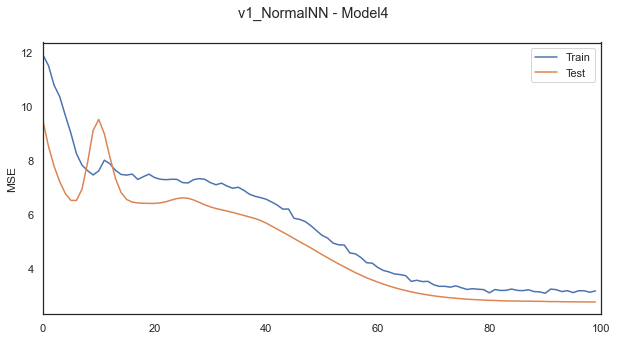

In [60]:
from matplotlib.ticker import FormatStrFormatter

plt.rcParams["figure.figsize"] = (10, 5)

loss_values4_backcalculated = [loss_v * len(modeling_dataset) for loss_v in loss_values4]

fig, axs = plt.subplots(1)
fig.suptitle("v1_NormalNN - Model4");

axs.plot(loss_values4_backcalculated, linestyle='-', label='Train', color='C0'); # Train
axs.plot(loss_values_test4, linestyle='-', label='Test', color='C1'); # Test
axs.legend();
axs.ticklabel_format(style='plain');
axs.set_xlim(0, num_epochs, 1);
axs.set_ylabel("MSE");

print(f"""
TRAIN
    min  : {np.min(loss_values4_backcalculated):2.8f}
    mean : {np.mean(loss_values4_backcalculated):2.8f}
    max  : {np.max(loss_values4_backcalculated):2.8f}
    sd   : {np.std(loss_values4_backcalculated):2.8f}
TEST
    min  : {np.min(loss_values_test4):2.8f}
    mean : {np.mean(loss_values_test4):2.8f}
    max  : {np.max(loss_values_test4):2.8f}
    sd   : {np.std(loss_values_test4):2.8f}
""")

---

# Add Convolutional Layers For The Cell Line Branch 

In [663]:
%load_ext autoreload
%autoreload 24
from v2_ConvNN              import ModelConv1
from my_utils.model_helpers import train_and_test_model


# ---------- #
# INITIALIZE #
# ---------- #
model_conv_1 = ModelConv1().to(device)
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)

# ---------------- #
# TRAIN & EVALUATE #
# ---------------- #
model_conv_1, loss_values_conv_1, loss_values_test_conv_1 = train_and_test_model(
    modeling_dataset = modeling_dataset,
    model            = model_conv_1,
    criterion        = loss_func,
    optimizer        = optimizer,
    num_epochs       = 50,
    device           = device,
    train_loader     = train_loader,
    test_loader      = test_loader
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


0it [00:42, ?it/s]


Epoch [1/50], Step [1/15], Loss: 11.5166
loss_values : 0.0000


4it [00:40, 10.10s/it]


MSE (test) : 10.088813781738281


0it [00:31, ?it/s]


Epoch [2/50], Step [1/15], Loss: 11.4004
loss_values : 0.0000


4it [00:44, 11.16s/it]


MSE (test) : 10.088812828063965


0it [00:36, ?it/s]


Epoch [3/50], Step [1/15], Loss: 11.5335
loss_values : 0.0000


4it [01:25, 21.33s/it]


MSE (test) : 10.088813781738281


0it [00:21, ?it/s]


Epoch [4/50], Step [1/15], Loss: 11.2634
loss_values : 0.0000


4it [00:46, 11.54s/it]


MSE (test) : 10.088813781738281


0it [00:18, ?it/s]


Epoch [5/50], Step [1/15], Loss: 11.4090
loss_values : 0.0000


4it [00:29,  7.38s/it]


MSE (test) : 10.088812828063965


0it [00:27, ?it/s]


Epoch [6/50], Step [1/15], Loss: 11.5087
loss_values : 0.0000


4it [00:46, 11.60s/it]


MSE (test) : 10.088812828063965


0it [00:19, ?it/s]


Epoch [7/50], Step [1/15], Loss: 11.4574
loss_values : 0.0000


4it [00:29,  7.43s/it]


MSE (test) : 10.088812828063965


0it [00:23, ?it/s]


Epoch [8/50], Step [1/15], Loss: 11.4955
loss_values : 0.0000


4it [00:32,  8.04s/it]


MSE (test) : 10.088814735412598


0it [00:20, ?it/s]


Epoch [9/50], Step [1/15], Loss: 11.4631
loss_values : 0.0000


4it [00:33,  8.44s/it]


MSE (test) : 10.088812828063965


0it [00:37, ?it/s]


Epoch [10/50], Step [1/15], Loss: 11.4591
loss_values : 0.0000


4it [01:08, 17.09s/it]


MSE (test) : 10.088812828063965


0it [00:26, ?it/s]


Epoch [11/50], Step [1/15], Loss: 11.5118
loss_values : 0.0000


4it [00:46, 11.62s/it]


MSE (test) : 10.088813781738281


0it [00:22, ?it/s]


Epoch [12/50], Step [1/15], Loss: 11.5822
loss_values : 0.0000


4it [00:43, 10.92s/it]


MSE (test) : 10.088812828063965


0it [00:21, ?it/s]


Epoch [13/50], Step [1/15], Loss: 11.3830
loss_values : 0.0000


4it [00:32,  8.14s/it]


MSE (test) : 10.088812828063965


0it [00:22, ?it/s]


Epoch [14/50], Step [1/15], Loss: 11.5064
loss_values : 0.0000


4it [00:35,  8.89s/it]


MSE (test) : 10.088813781738281


0it [00:25, ?it/s]


Epoch [15/50], Step [1/15], Loss: 11.4128
loss_values : 0.0000


4it [00:32,  8.18s/it]


MSE (test) : 10.088813781738281


0it [00:24, ?it/s]


Epoch [16/50], Step [1/15], Loss: 11.4256
loss_values : 0.0000


4it [01:25, 21.31s/it]


MSE (test) : 10.088812828063965


0it [00:22, ?it/s]


Epoch [17/50], Step [1/15], Loss: 11.3970
loss_values : 0.0000


4it [00:40, 10.12s/it]


MSE (test) : 10.088812828063965


0it [00:39, ?it/s]

Epoch [18/50], Step [1/15], Loss: 11.3886
loss_values : 0.0000



4it [01:04, 16.09s/it]


MSE (test) : 10.088813781738281


0it [00:37, ?it/s]


Epoch [19/50], Step [1/15], Loss: 11.5178
loss_values : 0.0000


4it [00:36,  9.02s/it]


MSE (test) : 10.088813781738281


0it [00:23, ?it/s]


Epoch [20/50], Step [1/15], Loss: 11.3803
loss_values : 0.0000


4it [00:39,  9.77s/it]


MSE (test) : 10.088813781738281


0it [00:26, ?it/s]


Epoch [21/50], Step [1/15], Loss: 11.4388
loss_values : 0.0000


4it [00:44, 11.12s/it]


MSE (test) : 10.088813781738281


0it [00:22, ?it/s]


Epoch [22/50], Step [1/15], Loss: 11.3953
loss_values : 0.0000


4it [00:43, 10.77s/it]


MSE (test) : 10.088812828063965


0it [00:25, ?it/s]


Epoch [23/50], Step [1/15], Loss: 11.3766
loss_values : 0.0000


4it [00:42, 10.57s/it]


MSE (test) : 10.088812828063965


0it [00:27, ?it/s]


Epoch [24/50], Step [1/15], Loss: 11.3827
loss_values : 0.0000


4it [00:32,  8.10s/it]


MSE (test) : 10.088813781738281


0it [00:21, ?it/s]


Epoch [25/50], Step [1/15], Loss: 11.5394
loss_values : 0.0000


4it [01:10, 17.56s/it]


MSE (test) : 10.088812828063965


0it [00:21, ?it/s]


Epoch [26/50], Step [1/15], Loss: 11.4552
loss_values : 0.0000


4it [00:33,  8.39s/it]


MSE (test) : 10.088813781738281


0it [00:25, ?it/s]


Epoch [27/50], Step [1/15], Loss: 11.6656
loss_values : 0.0000


4it [01:08, 17.04s/it]


MSE (test) : 10.088813781738281


0it [00:36, ?it/s]


Epoch [28/50], Step [1/15], Loss: 11.4701
loss_values : 0.0000


4it [01:07, 16.96s/it]


MSE (test) : 10.088813781738281


0it [00:59, ?it/s]

Epoch [29/50], Step [1/15], Loss: 11.4829
loss_values : 0.0000



4it [00:45, 11.30s/it]


MSE (test) : 10.088812828063965


0it [00:58, ?it/s]


Epoch [30/50], Step [1/15], Loss: 11.4548
loss_values : 0.0000


4it [01:04, 16.10s/it]


MSE (test) : 10.088813781738281


0it [01:20, ?it/s]


Epoch [31/50], Step [1/15], Loss: 11.4288
loss_values : 0.0000


4it [01:38, 24.74s/it]


MSE (test) : 10.088813781738281


0it [00:39, ?it/s]


Epoch [32/50], Step [1/15], Loss: 11.3736
loss_values : 0.0000


4it [00:57, 14.48s/it]


MSE (test) : 10.088813781738281


0it [02:03, ?it/s]


Epoch [33/50], Step [1/15], Loss: 11.5681
loss_values : 0.0000


4it [01:25, 21.47s/it]


MSE (test) : 10.088812828063965


0it [00:41, ?it/s]


Epoch [34/50], Step [1/15], Loss: 11.6281
loss_values : 0.0000


4it [01:15, 18.94s/it]


MSE (test) : 10.088812828063965


0it [00:28, ?it/s]


Epoch [35/50], Step [1/15], Loss: 11.4455
loss_values : 0.0000


4it [00:34,  8.55s/it]


MSE (test) : 10.088812828063965


0it [01:08, ?it/s]


Epoch [36/50], Step [1/15], Loss: 11.4792
loss_values : 0.0000


4it [01:35, 23.88s/it]


MSE (test) : 10.088812828063965


0it [00:44, ?it/s]


Epoch [37/50], Step [1/15], Loss: 11.5833
loss_values : 0.0000


4it [01:08, 17.23s/it]


MSE (test) : 10.088813781738281


0it [00:31, ?it/s]


Epoch [38/50], Step [1/15], Loss: 11.4118
loss_values : 0.0000


4it [01:27, 21.84s/it]


MSE (test) : 10.088813781738281


0it [00:59, ?it/s]

Epoch [39/50], Step [1/15], Loss: 11.6167
loss_values : 0.0000



4it [01:01, 15.39s/it]


MSE (test) : 10.088813781738281


0it [00:47, ?it/s]


Epoch [40/50], Step [1/15], Loss: 11.5165
loss_values : 0.0000


4it [01:32, 23.21s/it]


MSE (test) : 10.088812828063965


0it [00:33, ?it/s]


Epoch [41/50], Step [1/15], Loss: 11.5007
loss_values : 0.0000


4it [01:21, 20.43s/it]


MSE (test) : 10.088813781738281


0it [00:38, ?it/s]


Epoch [42/50], Step [1/15], Loss: 11.4688
loss_values : 0.0000


4it [00:56, 14.14s/it]


MSE (test) : 10.088812828063965


0it [00:25, ?it/s]


Epoch [43/50], Step [1/15], Loss: 11.4676
loss_values : 0.0000


4it [00:33,  8.41s/it]


MSE (test) : 10.088813781738281


0it [00:25, ?it/s]


Epoch [44/50], Step [1/15], Loss: 11.4361
loss_values : 0.0000


4it [00:34,  8.52s/it]


MSE (test) : 10.088812828063965


0it [00:20, ?it/s]


Epoch [45/50], Step [1/15], Loss: 11.3556
loss_values : 0.0000


4it [00:28,  7.16s/it]


MSE (test) : 10.088813781738281


0it [00:21, ?it/s]


Epoch [46/50], Step [1/15], Loss: 11.5674
loss_values : 0.0000


4it [00:53, 13.31s/it]


MSE (test) : 10.088812828063965


0it [00:21, ?it/s]


Epoch [47/50], Step [1/15], Loss: 11.5887
loss_values : 0.0000


4it [00:31,  7.76s/it]


MSE (test) : 10.088813781738281


0it [00:18, ?it/s]


Epoch [48/50], Step [1/15], Loss: 11.3938
loss_values : 0.0000


4it [00:30,  7.65s/it]


MSE (test) : 10.088812828063965


0it [00:19, ?it/s]


Epoch [49/50], Step [1/15], Loss: 11.4817
loss_values : 0.0000


4it [00:41, 10.32s/it]


MSE (test) : 10.088813781738281


0it [00:20, ?it/s]


Epoch [50/50], Step [1/15], Loss: 11.5680
loss_values : 0.0000


4it [00:28,  7.17s/it]


MSE (test) : 10.088812828063965



TRAIN
    min  : 0.00003036
    mean : 0.00003092
    max  : 0.00003145
TEST
    min  : 0.00002720
    mean : 0.00002720
    max  : 0.00002720



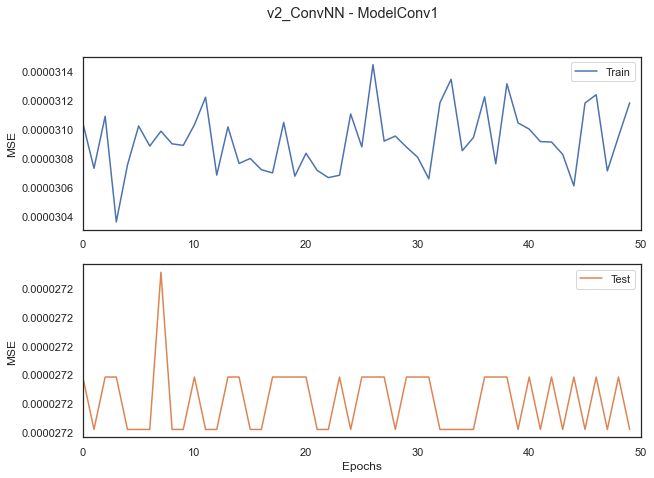

In [665]:
from matplotlib.ticker import FormatStrFormatter

plt.rcParams["figure.figsize"] = (10, 7)

fig, axs = plt.subplots(2)
fig.suptitle("v2_ConvNN - ModelConv1");
# Train
axs[0].plot(loss_values_conv_1, linestyle='-', label='Train', color='C0');
axs[0].legend();
axs[0].ticklabel_format(style='plain');
axs[0].set_xlim(0, 50, 1);
axs[0].set_ylabel("MSE");
# Test
axs[1].plot([loss_v / len(modeling_dataset) for loss_v in loss_values_test_conv_1], linestyle='-', label='Test', color='C1');
axs[1].legend();
# axs[1].ticklabel_format(style='plain');
axs[1].yaxis.set_major_formatter(FormatStrFormatter('%.7f'))
axs[1].set_xlim(0, 50, 1);
axs[1].set_xlabel("Epochs");
axs[1].set_ylabel("MSE");

print(f"""
TRAIN
    min  : {np.min(loss_values_conv_1):2.8f}
    mean : {np.mean(loss_values_conv_1):2.8f}
    max  : {np.max(loss_values_conv_1):2.8f}
TEST
    min  : {np.min([loss_v / len(modeling_dataset) for loss_v in loss_values_test_conv_1]):2.8f}
    mean : {np.mean([loss_v / len(modeling_dataset) for loss_v in loss_values_test_conv_1]):2.8f}
    max  : {np.max([loss_v / len(modeling_dataset) for loss_v in loss_values_test_conv_1]):2.8f}
""")



In [ ]:
# Flattening explained.
t = torch.rand(20000, 32, 128)
print(t.shape)
print(torch.flatten(t, start_dim=1, end_dim=2).shape)

In [648]:
t2 = torch.rand(20000, 4096)
print(t2.shape)
print(t2.reshape(t2.shape[0], 1, t2.shape[1]).shape)

torch.Size([20000, 4096])
torch.Size([20000, 1, 4096])


In [202]:
gene_expr_data

tensor([[7.4722, 5.8678, 4.9159,  ..., 6.6141, 8.5520, 3.2697],
        [7.4081, 6.1157, 6.0675,  ..., 3.6499, 6.8504, 3.5596],
        [7.2114, 7.4453, 5.6951,  ..., 3.6498, 8.3988, 3.8715],
        ...,
        [7.0449, 6.8248, 4.8239,  ..., 4.6832, 9.6526, 3.7312],
        [7.1434, 6.8708, 6.0484,  ..., 7.9259, 8.3798, 3.4813],
        [7.5782, 7.3208, 5.1952,  ..., 7.5937, 7.9628, 3.4822]],
       dtype=torch.float64)

In [132]:
np1 = np.array([[1], 
                [2]])
np2 = np.array([[3], 
                [4]])
np3 = np.array([[5], 
                [6]])

"""
1.dim = features
2.dim = cell-lines
3.dim = genes
"""

t = torch.tensor([np1, np2, np3])
print(t.shape)
t

torch.Size([3, 2, 1])


tensor([[[1],
         [2]],

        [[3],
         [4]],

        [[5],
         [6]]])

In [138]:
t2 = torch.flatten(t, start_dim=1)
t2

tensor([[1, 2],
        [3, 4],
        [5, 6]])

In [154]:
np.reshape(t, (2, 3), order='F')

tensor([[1, 5, 4],
        [3, 2, 6]])

In [156]:
np.ravel(t, order='F').reshape((2, t.shape[0] * t.shape[2]))

array([[1, 3, 5],
       [2, 4, 6]])

# Bi-Modal Model Using CNV Gistic

In [14]:
# --------------------- #
# CREATE THE GENE LAYER #
# --------------------- #
used_genes = list(cnv_gistic_v4.loc[:, cnv_gistic_v4.columns != 'CELL_LINE_NAME'].columns)
MAPPING_FROM_GENES_TO_INDICES = pd.DataFrame(used_genes, columns=['genes']).reset_index(level=0)

GENE_LAYER_VALUES = torch.tensor(MAPPING_FROM_GENES_TO_INDICES.index.values)
print(f"Gene layer shape : {GENE_LAYER_VALUES.shape}")
print(GENE_LAYER_VALUES[:5])
# TODO: check that this is the same mapping as it is when using gene 'gene_expr_v4'
MAPPING_FROM_GENES_TO_INDICES.head(5)

Gene layer shape : torch.Size([870])
tensor([0, 1, 2, 3, 4])


,index,genes
0,0,ATP6V1D
1,1,NPDC1
2,2,CIAPIN1
3,3,GNPDA1
4,4,SESN1


In [15]:
# ----------------------------------------- #
# CREATE THE GENE LAYER only for CNV GISTIC #
# ----------------------------------------- #
non_gene_cols = [
    'DRUG_ID', 'CELL_LINE_NAME', 'AUC', 'CELL_ID', 'LN_IC50', 'CONC',
    'MASTER_CELL_ID', 'INTENSITY', 'DATASET', 'Z_SCORE', 'DRUG_NAME',
    'RMSE', 'COSMIC_ID', 'POSITION'
]

gene_cols__cnvgistic = final_cnv_gistic.loc[:, ~final_cnv_gistic.columns.isin(non_gene_cols)]
cnv_gistic_v2 = final_cnv_gistic[['CELL_LINE_NAME'] + list(gene_cols__cnvgistic.columns)].drop_duplicates()

used_genes = list(cnv_gistic_v2.loc[:, cnv_gistic_v2.columns != 'CELL_LINE_NAME'].columns)
MAPPING_FROM_GENES_TO_INDICES__CnvGistic = pd.DataFrame(used_genes, columns=['genes']).reset_index(level=0)

GENE_LAYER_VALUES = torch.tensor(MAPPING_FROM_GENES_TO_INDICES__CnvGistic.index.values)
print(f"Gene layer shape : {GENE_LAYER_VALUES.shape}")
print(GENE_LAYER_VALUES[:5])
MAPPING_FROM_GENES_TO_INDICES__CnvGistic.head(5)

Gene layer shape : torch.Size([938])
tensor([0, 1, 2, 3, 4])


,index,genes
0,0,AARS
1,1,ABCB6
2,2,ABCC5
3,3,ABCF1
4,4,ABCF3


In [16]:
# ---------------------------------------------- #
# CREATE THE GENE LAYER only for GENE EXPRESSION #
# ---------------------------------------------- #
non_gene_cols = [
    'DRUG_ID', 'CELL_LINE_NAME', 'AUC', 'CELL_ID', 'LN_IC50', 'CONC',
    'MASTER_CELL_ID', 'INTENSITY', 'DATASET', 'Z_SCORE', 'DRUG_NAME',
    'RMSE', 'COSMIC_ID', 'POSITION'
]

gene_cols__geneexpr = gene_expr.loc[:, ~gene_expr.columns.isin(non_gene_cols)]
gene_expr_v2 = gene_expr[['CELL_LINE_NAME'] + list(gene_cols__geneexpr.columns)].drop_duplicates()

used_genes = list(gene_expr_v2.loc[:, gene_expr_v2.columns != 'CELL_LINE_NAME'].columns)
MAPPING_FROM_GENES_TO_INDICES__GeneExpr = pd.DataFrame(used_genes, columns=['genes']).reset_index(level=0)

GENE_LAYER_VALUES = torch.tensor(MAPPING_FROM_GENES_TO_INDICES__GeneExpr.index.values)
print(f"Gene layer shape : {GENE_LAYER_VALUES.shape}")
print(GENE_LAYER_VALUES[:5])
MAPPING_FROM_GENES_TO_INDICES__GeneExpr.head(5)

Gene layer shape : torch.Size([908])
tensor([0, 1, 2, 3, 4])


,index,genes
0,0,TSPAN6
1,1,SCYL3
2,2,BAD
3,3,LAP3
4,4,SNX11


In [17]:
intersections = set(MAPPING_FROM_GENES_TO_INDICES__GeneExpr.genes.values).intersection(set(MAPPING_FROM_GENES_TO_INDICES__CnvGistic.genes.values))
print(len(intersections))
list(intersections)[:10]

871


['ATP6V1D',
 'NPDC1',
 'CIAPIN1',
 'GNPDA1',
 'SESN1',
 'TSPAN3',
 'NR2F6',
 'GATA3',
 'RB1',
 'CCNA2']

In [18]:
MAPPING_FROM_GENES_TO_INDICES__intersection = MAPPING_FROM_GENES_TO_INDICES__CnvGistic[MAPPING_FROM_GENES_TO_INDICES__CnvGistic.genes.isin(intersections)]
MAPPING_FROM_GENES_TO_INDICES__intersection.shape

(871, 2)

In [19]:
print(f"with NaN: {final_cnv_gistic.shape}")
print(f"w/o  NaN: {final_cnv_gistic.dropna().shape}")

with NaN: (446521, 952)
w/o  NaN: (438144, 952)


In [20]:
final_cnv_gistic.head(5)

,MASTER_CELL_ID,CELL_ID,CONC,CELL_LINE_NAME,RMSE,AUC,INTENSITY,COSMIC_ID,DRUG_NAME,POSITION,...,ZMIZ1,ZMYM2,ZNF131,ZNF274,ZNF318,ZNF395,ZNF451,ZNF586,ZNF589,ZW10
0,49,3137,2.0,MC-CAR,0.022521,0.982114,544404,683665,Erlotinib,14,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-2.0
9,1342,2366,2.0,ES3,0.031840,0.984816,404197,684055,Erlotinib,14,...,-1.0,-1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
27,610,2368,2.0,ES5,0.026052,0.985693,797378,684057,Erlotinib,14,...,-1.0,-1.0,-1.0,-1.0,0.0,1.0,1.0,-1.0,0.0,-1.0
45,71,2371,2.0,ES7,0.110056,0.972699,377574,684059,Erlotinib,14,...,-1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,-1.0,-1.0
54,231,2375,2.0,EW-11,0.087011,0.944462,638065,684062,Erlotinib,14,...,-1.0,-1.0,1.0,-1.0,0.0,1.0,0.0,-1.0,-1.0,0.0


In [21]:
from typing import List
import copy

class ModelDataset(Dataset): 
    def __init__(self, 
                 full_data: pd.DataFrame,
                 cell_cols: List[str],
                 drug_cols: List[str],
                 cell_identifier: str,
                 drug_identifier: str,
                 corresponding_fps: pd.DataFrame = FPS,
                 target_col: str='LN_IC50'): 
        # Drop all nans. 
        print(f"Initial shape before removing NaN's : {full_data.shape}")
        full_data = full_data.dropna()
        print(f"Shape after removing all NaN's      : {full_data.shape}")

        X = full_data[cell_cols + drug_cols]
        y = full_data[target_col]

        fps = pd.merge(left     = full_data['DRUG_ID'], 
                       right    = drug_name_fps_v2.loc[:, ~drug_name_fps_v2.columns.isin(['drug_name'])], 
                       how      = 'left', 
                       left_on  = ['DRUG_ID'], 
                       right_on = ['DRUG_ID'])

        X_cell = X[cell_cols]
        X_drug = copy.deepcopy(fps)

        print(f"X_cell.shape : {X_cell.shape}")
        print(f"X_drug.shape : {X_drug.shape}")

        # Contains only the gene columns and the respective feature value. Here GeneExpression.
        self.X = torch.tensor(X.loc[:, ~X.columns.isin([cell_identifier] + ['DRUG_NAME'])].values, dtype=torch.float32)
        self.X_cell = torch.tensor(X_cell.loc[:, ~X_cell.columns.isin([cell_identifier])].values, dtype=torch.float32)
        self.X_drug = torch.tensor(X_drug.loc[:, ~X_drug.columns.isin([drug_identifier])].values, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.float32)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.X_cell[idx], self.X_drug[idx], self.y[idx]

In [22]:
print(final_cnv_gistic.shape)
final_cnv_gistic.loc[:, ~final_cnv_gistic.columns.isin(['AUC', 'CELL_ID', 'CONC', 'MASTER_CELL_ID', 'INTENSITY', 'DATASET', 'Z_SCORE', 'COSMIC_ID', 'POSITION'])].head(3)

(446521, 952)


,CELL_LINE_NAME,RMSE,DRUG_NAME,LN_IC50,DRUG_ID,AARS,ABCB6,ABCC5,ABCF1,ABCF3,...,ZMIZ1,ZMYM2,ZNF131,ZNF274,ZNF318,ZNF395,ZNF451,ZNF586,ZNF589,ZW10
0,MC-CAR,0.022521,Erlotinib,2.395685,1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-2.0
9,ES3,0.031840,Erlotinib,3.140923,1,0.0,0.0,0.0,0.0,0.0,...,-1.0,-1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
27,ES5,0.026052,Erlotinib,3.968757,1,-1.0,1.0,0.0,0.0,0.0,...,-1.0,-1.0,-1.0,-1.0,0.0,1.0,1.0,-1.0,0.0,-1.0


In [28]:
# --------------------------------------------------- #
# Delete all rows from the dataset for which there is #
# no fingerprint for the specific drug.               #
# --------------------------------------------------- #
dataset_to_use = copy.deepcopy(final_cnv_gistic)

# Dataset for modeling which has fingerprints for each DRUG_ID.
all_drugs_with_fps = np.unique(drug_name_fps_v2.DRUG_ID).tolist()
modeling_dataset = dataset_to_use[dataset_to_use.DRUG_ID.isin(all_drugs_with_fps)]

uniq_drugs_in__modeling_dataset = len(np.unique(modeling_dataset.DRUG_ID.values))
uniq_drugs_with__fingerprints = len(np.unique(drug_name_fps_v2.DRUG_ID).tolist())

assert uniq_drugs_in__modeling_dataset == uniq_drugs_with__fingerprints,\
    f"ERROR: Modeling dataset has {uniq_drugs_in__modeling_dataset} DRUG_ID's while there are only {uniq_drugs_with__fingerprints} DRUG_ID's with fingerprints."

In [30]:
all_genes = list(MAPPING_FROM_GENES_TO_INDICES__intersection.genes.values)
print(len(all_genes))
modeling_dataset.dtypes

871


MASTER_CELL_ID      int64
CELL_ID             int64
CONC              float64
CELL_LINE_NAME     object
RMSE              float64
                   ...   
ZNF395             object
ZNF451             object
ZNF586             object
ZNF589             object
ZW10               object
Length: 952, dtype: object

In [53]:
start = time.time()
modeling_dataset_converted = convert_column_types(df              = modeling_dataset,
                                                  cols_to_convert = all_genes,
                                                  conversion_type = 'float64')
print(f"Elapsed time to convert the {len(all_genes)} columns: {time.time() - start:2.2f} seconds.")

/Users/cwoest/Documents/Academics/Data_Science_UP/master_thesis/material/GNN-material/my_utils/preprocessing_helpers.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_converted = pd.concat([df_subset, converted_subset], axis=1) # df_converted = converted_subset.copy()
/Users/cwoest/Documents/Academics/Data_Science_UP/master_thesis/material/GNN-material/my_utils/preprocessing_helpers.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_converted = pd.concat([df_subset, converted_subset], axis=1) # d

Elapsed time to convert the 871 columns: 201.66 seconds.


/Users/cwoest/Documents/Academics/Data_Science_UP/master_thesis/material/GNN-material/my_utils/preprocessing_helpers.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_converted = pd.concat([df_subset, converted_subset], axis=1) # df_converted = converted_subset.copy()
/Users/cwoest/Documents/Academics/Data_Science_UP/master_thesis/material/GNN-material/my_utils/preprocessing_helpers.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_converted = pd.concat([df_subset, converted_subset], axis=1) # df_converted

In [55]:
modeling_dataset_converted.dtypes

MASTER_CELL_ID      int64
CELL_ID             int64
CONC              float64
CELL_LINE_NAME     object
RMSE              float64
                   ...   
ZNF318            float64
ZNF395            float64
ZNF451            float64
ZNF586            float64
ZNF589            float64
Length: 952, dtype: object

In [114]:
# Save CNV Gistic file.
modeling_dataset_converted.to_pickle(f'{PATH_TO_SAVE_DATA_TO}cnv_gistic_converted.pkl')

In [24]:
# Read the CNV Gistic file.
modeling_dataset_converted = pd.read_pickle(f'{PATH_TO_SAVE_DATA_TO}cnv_gistic_converted.pkl')
print(f"Shape: {modeling_dataset_converted.shape}")
modeling_dataset_converted.head(3)

Shape: (370963, 952)


,MASTER_CELL_ID,CELL_ID,CONC,CELL_LINE_NAME,RMSE,AUC,INTENSITY,COSMIC_ID,DRUG_NAME,POSITION,...,ZFP36,ZMIZ1,ZMYM2,ZNF131,ZNF274,ZNF318,ZNF395,ZNF451,ZNF586,ZNF589
0,49,3137,2.0,MC-CAR,0.022521,0.982114,544404,683665,Erlotinib,14,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,1342,2366,2.0,ES3,0.031840,0.984816,404197,684055,Erlotinib,14,...,0.0,-1.0,-1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
27,610,2368,2.0,ES5,0.026052,0.985693,797378,684057,Erlotinib,14,...,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,1.0,1.0,-1.0,0.0


In [30]:
CELL_IDENTIFIER = 'CELL_LINE_NAME'
DRUG_IDENTIFIER = 'DRUG_ID'
TARGET_IDENTIFIER = 'LN_IC50'

# ---------------------------- #
# Create the modeling dataset. #
# ---------------------------- #
model_dataset = ModelDataset(full_data       = modeling_dataset_converted,
                             cell_cols       = [CELL_IDENTIFIER] + list(MAPPING_FROM_GENES_TO_INDICES__intersection.genes.values),
                             drug_cols       = [DRUG_IDENTIFIER, 'DRUG_NAME'],
                             cell_identifier = CELL_IDENTIFIER,
                             drug_identifier = DRUG_IDENTIFIER,
                             target_col      = TARGET_IDENTIFIER)

assert torch.isnan(model_dataset.X_drug).any() == False,\
    "ERROR: Some drugs in the dataset have no fingerprints."

Initial shape before removing NaN's : (370963, 952)
Shape after removing all NaN's      : (363949, 952)
X_cell.shape : (363949, 872)
X_drug.shape : (363949, 257)


__TODO__: Filter out NaNs. In a tensor do `model_dataset.X[~torch.any(model_dataset.X.isnan(),dim=1)]`

In [31]:
train_set_split_ratio = 0.8

train_size = int(train_set_split_ratio * len(model_dataset))
test_size = len(model_dataset) - train_size
train_set, test_set = torch.utils.data.random_split(model_dataset, 
                                                    [train_size, test_size],
                                                    generator=torch.Generator().manual_seed(42))

print(f"""
    Shapes 
        Train : 
            X : {train_set.dataset.X.shape}
                X_cell : {train_set.dataset.X_cell.shape}
                X_drug : {train_set.dataset.X_drug.shape}
            y : {train_set.dataset.y.shape}
        Test  :
            X : {test_set.dataset.X.shape}
                X_cell : {test_set.dataset.X_cell.shape}
                X_drug : {test_set.dataset.X_drug.shape}            
            y : {test_set.dataset.y.shape}
""")
# TODO: why does the test set have the same shape?                                                  


    Shapes 
        Train : 
            X : torch.Size([363949, 872])
                X_cell : torch.Size([363949, 871])
                X_drug : torch.Size([363949, 256])
            y : torch.Size([363949])
        Test  :
            X : torch.Size([363949, 872])
                X_cell : torch.Size([363949, 871])
                X_drug : torch.Size([363949, 256])            
            y : torch.Size([363949])



In [69]:
train_set.dataset.X

tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  1.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          1.0000e+00,  1.0000e+00],
        [-1.0000e+00,  0.0000e+00,  0.0000e+00,  ..., -1.0000e+00,
          0.0000e+00,  1.0000e+00],
        ...,
        [ 0.0000e+00,  1.0000e+00,  1.0000e+00,  ..., -1.0000e+00,
          0.0000e+00,  2.1720e+03],
        [-1.0000e+00,  1.0000e+00,  1.0000e+00,  ...,  1.0000e+00,
          1.0000e+00,  2.1720e+03],
        [ 0.0000e+00,  2.0000e+00, -1.0000e+00,  ...,  0.0000e+00,
         -1.0000e+00,  2.1720e+03]])

In [70]:
train_set.dataset.X_cell

tensor([[ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  ...,  0.,  0.,  1.],
        [-1.,  0.,  0.,  ...,  1., -1.,  0.],
        ...,
        [ 0.,  1.,  1.,  ...,  1., -1.,  0.],
        [-1.,  1.,  1.,  ...,  1.,  1.,  1.],
        [ 0.,  2., -1.,  ...,  0.,  0., -1.]])

In [71]:
train_set.dataset.X_drug

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

__Note__: 
- The very last entry per row is the `DRUG_ID`
- It can be accessed by `model_dataset[<cell-line-number>, -1]`

In [28]:
# ---------------- # 
# Hyper-parameters #
# ---------------- #
input_size   = 910 # which is gene_expr_base.shape[0]-1 = 911 - 1
                   # One value per feature
hidden_size   = 100
num_classes   = 1
num_epochs    = 100
batch_size    = 20_000
learning_rate = 0.001   

In [32]:
# Data loader
train_loader = torch.utils.data.DataLoader(dataset     = train_set, 
                                           batch_size  = batch_size, 
                                           shuffle     = True,
                                           num_workers = 0)

test_loader = torch.utils.data.DataLoader(dataset     = test_set, 
                                          batch_size  = batch_size, 
                                          shuffle     = True,
                                          num_workers = 0) 

In [33]:
count = sum(1 for X, X_cell, X_drug, y in train_loader)
print(f"train batch count : {count}") 

count = sum(1 for X, X_cell, X_drug, y in test_loader)
print(f"test batch count  : {count}") 

train batch count : 15
test batch count  : 4


In [25]:
%load_ext autoreload
%autoreload 24
from v1_NormalNN import Model2CnvGistic

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [35]:
%load_ext autoreload
%autoreload 2
from v1_NormalNN            import Model2CnvGistic
from my_utils.model_helpers import train_and_test_model

torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

# ---------- #
# INITIALIZE #
# ---------- #
model_cnv_gistic = Model2CnvGistic().to(device)
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(params = model_cnv_gistic.parameters(), 
                             lr     = learning_rate)

# ---------------- #
# TRAIN & EVALUATE #
# ---------------- #
model_cnv_gistic, loss_values_cnv_gistic, loss_values__cnv_gistic = train_and_test_model(modeling_dataset = model_dataset,
                                                                                         model            = model_cnv_gistic,
                                                                                         criterion        = loss_func,
                                                                                         optimizer        = optimizer,
                                                                                         num_epochs       = 100,
                                                                                         device           = device,
                                                                                         train_loader     = train_loader,
                                                                                         test_loader      = test_loader)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Device: cpu


0it [00:02, ?it/s]


Epoch [1/100], Step [1/15], Loss: 12.0326
loss_values : 0.0000


4it [00:07,  1.83s/it]


MSE (test) : 10.940505027770996


0it [00:02, ?it/s]


Epoch [2/100], Step [1/15], Loss: 12.0116
loss_values : 0.0000


4it [00:08,  2.00s/it]


MSE (test) : 10.940505027770996


0it [00:02, ?it/s]


Epoch [3/100], Step [1/15], Loss: 12.0907
loss_values : 0.0000


1it [00:03,  3.97s/it]


KeyboardInterrupt: 

In [ ]:
from matplotlib.ticker import FormatStrFormatter

plt.rcParams["figure.figsize"] = (10, 5)

loss_values_backcalculated = [loss_v * len(modeling_dataset) for loss_v in loss_values_cnv_gistic]

fig, axs = plt.subplots(1)
fig.suptitle("v1_NormalNN - Model4");

axs.plot(loss_values_backcalculated, linestyle='-', label='Train', color='C0'); # Train
axs.plot(loss_values_test, linestyle='-', label='Test', color='C1'); # Test
axs.legend();
axs.ticklabel_format(style='plain');
axs.set_xlim(0, num_epochs, 1);
axs.set_ylabel("MSE");

print(f"""
TRAIN
    min  : {np.min(loss_values_backcalculated):2.8f}
    mean : {np.mean(loss_values_backcalculated):2.8f}
    max  : {np.max(loss_values_backcalculated):2.8f}
    sd   : {np.std(loss_values_backcalculated):2.8f}
TEST
    min  : {np.min(loss_values_test):2.8f}
    mean : {np.mean(loss_values_test):2.8f}
    max  : {np.max(loss_values_test):2.8f}
    sd   : {np.std(loss_values_test):2.8f}
""")

# Bi-Modal Model Using CNV Picnic

---

## Drug Features

In [27]:
with open(f'{PATH_TO_SAVED_DRUG_FEATURES}drug_name_fingerprints_dataframe.pkl', 'rb') as f:
    drug_name_fps = pickle.load(f)
print(f"Shape: {drug_name_fps.shape}")
drug_name_fps.head(3)   

Shape: (367, 257)


,drug_name,0,1,2,3,4,5,6,7,8,...,246,247,248,249,250,251,252,253,254,255
0,(5Z)-7-Oxozeaenol,1,0,0,1,1,0,0,0,0,...,0,0,0,0,0,1,1,0,1,0
1,5-Fluorouracil,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,A-443654,0,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1


The encoded drug feature dataset has 367 unique drug names and per drug name a 256 sized De-Morgan fingerprint.